# Notebook Summary: Outlier Detection, PCA, and Momentum Strategies in Energy Sector Analysis  

This notebook provides a comprehensive approach to analyzing historical price data in the energy sector, integrating methods for outlier detection, principal component analysis (PCA), and momentum-based trading strategies. The workflow is divided into data preparation, exploratory analysis, and advanced modeling to uncover market trends and evaluate trading signals.

---

## **Key Components**  

### **Outlier Detection**
1. **Techniques Used**:  
   - **Tukey's IQR Method**: Identifies price outliers based on interquartile range (IQR).  
   - **Z-Score Method**: Flags extreme values by standard deviations from the mean.  

2. **Results**:  
   - **Ticker Analysis**:  
     - Outliers were notably high for tickers like `TTE`, `PBR`, and `SU`, reflecting periods of significant volatility.  
     - Leveraged ETFs such as `SCO` and `UCO` also showed substantial outliers, aligning with their inherent high-risk profile.  
   - **Summary**:  
     | Ticker | IQR Outliers | Z-Score Outliers |  
     |--------|--------------|------------------|  
     | XOM    | 0            | 0                |  
     | CVX    | 69           | 5                |  
     | TTE    | 421          | 212              |  
     | PBR    | 613          | 136              |  
     | SU     | 739          | 176              |  
     | ...    | ...          | ...              |  

3. **Insights**:  
   - Outliers highlight periods of heightened volatility, often linked to geopolitical or macroeconomic shocks, especially in emerging market tickers like `PBR`.  

---

### **Principal Component Analysis (PCA)**
1. **Standardization**:  
   - Numeric features were standardized to ensure comparability across variables.  

2. **Variance Explained**:  
   - PC1 captured **80.05%** of the variance, primarily driven by price variables (`open`, `high`, `low`, `close`).  
   - PC2 accounted for **19.93%**, predominantly influenced by **volume**.  

3. **Feature Contributions**:  
   | Feature   | PC1 Contribution | PC2 Contribution |  
   |-----------|------------------|------------------|  
   | open      | 0.4997           | 0.0167           |  
   | high      | 0.4997           | 0.0145           |  
   | low       | 0.4997           | 0.0191           |  
   | close     | 0.4997           | 0.0168           |  
   | volume    | 0.0335           | 0.9994           |  

4. **Enhanced Biplots**:  
   - Scatter plots with variable loadings highlight that price data dominates PC1, while PC2 isolates volume-driven trends.  

---

### **Momentum-Based Trading Strategies**
1. **Signal Generation**:  
   - **Time-Series Momentum (TS)**: Uses rolling short and long-term averages to create directional signals.  
   - **Cross-Sectional Momentum (XS)**: Ranks stocks by momentum for relative positioning.  

2. **Performance Metrics**:  
   - **Sharpe Ratios**:  
     - Time-series momentum strategy underperformed with a Sharpe ratio of **-0.32** due to noise and transaction costs.  
     - A buy-and-hold benchmark outperformed with a Sharpe ratio of **0.58**.  
   - **Turnover and Holding Period**:  
     - Average turnover was **25.9%**, resulting in an average holding period of **7.7 days**.  

3. **Buy/Sell Signals**:  
   - Moving average crossover strategies visualized alongside cumulative returns for individual tickers.  

---

### **Exploratory and Time-Series Analysis**
1. **Stationarity**:  
   - Augmented Dickey-Fuller (ADF) tests confirmed stationarity for most tickers.  
   - Exceptions like `NOEMU` had a non-stationary price series with a p-value of **0.197**.  

2. **STL Decomposition**:  
   - Seasonal-trend decomposition revealed cyclical and long-term trends for closing prices.  

---

### **Key Findings**
- **Outlier Trends**:  
   - High outlier density in leveraged ETFs (`SCO`, `UCO`) and emerging market stocks (`PBR`, `SU`).  
- **PCA Insights**:  
   - PC1 is price-driven, while PC2 isolates volume trends, suggesting different drivers for variance.  
- **Momentum Strategies**:  
   - Short-term momentum strategies were hindered by transaction costs and noise, with a **negative Sharpe ratio** for the strategy.  

---

### **Next Steps**
1. **Model Refinements**:  
   - Explore machine learning approaches like clustering and predictive models for signal enhancement.  
   - Include exogenous variables such as oil prices, interest rates, or geopolitical events in time-series models.  

2. **Portfolio Analysis**:  
   - Backtest portfolio optimization strategies combining TS and XS momentum signals.  

3. **Scalability**:  
   - Adapt methods to analyze additional sectors or broader market indices.  

---

This notebook serves as a robust framework for analyzing energy sector price data, offering insights for academic research, investment strategies, and quantitative modeling. Further refinements and integration with macroeconomic variables can enhance its predictive power.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

# Load the data
data = pd.read_csv("combined_data.csv")
data['date'] = pd.to_datetime(data['date'])  # Convert 'date' column to datetime
data.set_index('date', inplace=True)  # Set 'date' as the index for time-series analysis
print(data.head())

# Filter data for a specific ticker for outlier analysis (e.g., XOM)
ticker_data = data[data['ticker'] == 'XOM']

# --- Outlier Detection Methods ---

# Tukey's IQR Method
def iqr_outliers(data_column):
    q1 = np.percentile(data_column, 25)  # 1st quartile
    q3 = np.percentile(data_column, 75)  # 3rd quartile
    iqr = q3 - q1  # Interquartile range
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    return data_column[(data_column < lower_fence) | (data_column > upper_fence)]

# Z-Score Method
def zscore_outliers(data_column, threshold=3):
    mean = np.mean(data_column)
    std = np.std(data_column)
    z_scores = (data_column - mean) / std
    return data_column[(z_scores < -threshold) | (z_scores > threshold)]

           Unnamed: 0  1. open  2. high    3. low  4. close   5. volume ticker
date                                                                          
2024-12-06        XOM   114.54   114.77  113.5000    113.57  15740884.0    XOM
2024-12-05        XOM   114.71   115.62  114.0600    114.78  15751204.0    XOM
2024-12-04        XOM   117.50   117.55  113.8612    114.28  19520583.0    XOM
2024-12-03        XOM   118.72   118.72  117.2550    117.67  11756566.0    XOM
2024-12-02        XOM   118.05   118.20  116.8200    117.85  12687317.0    XOM


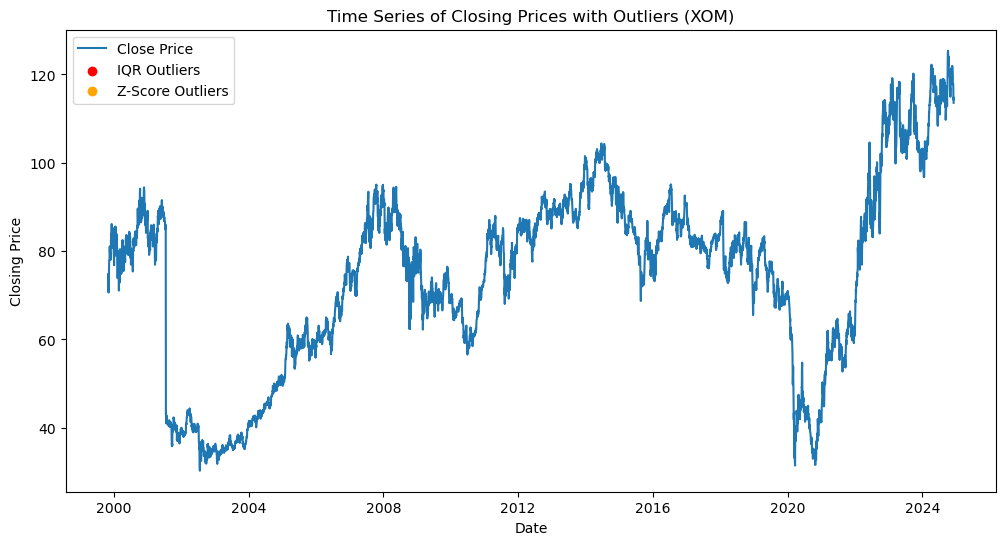

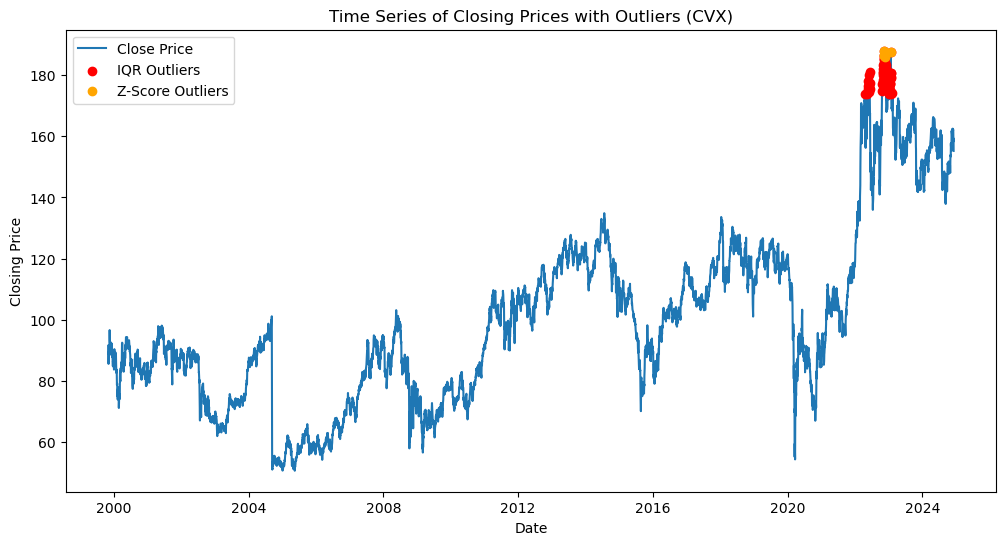

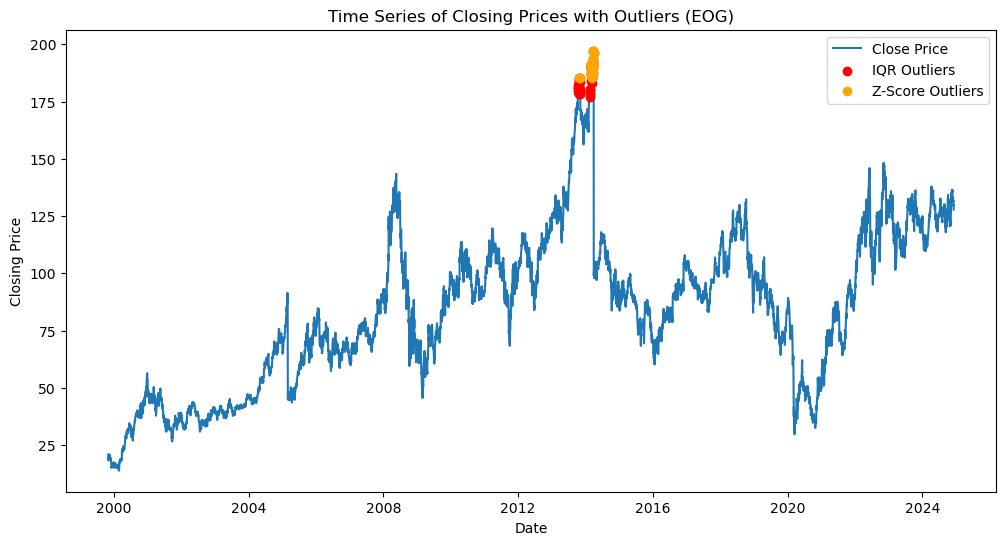

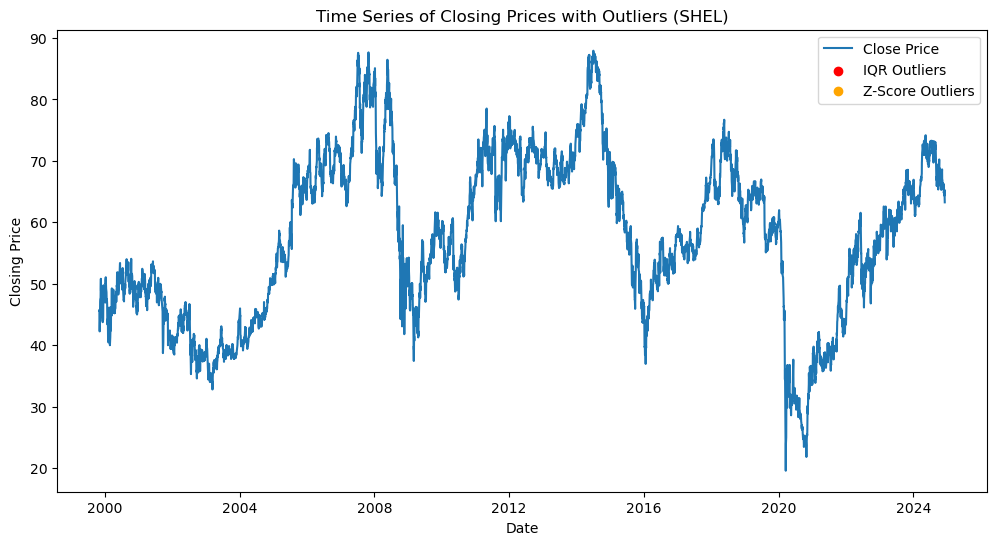

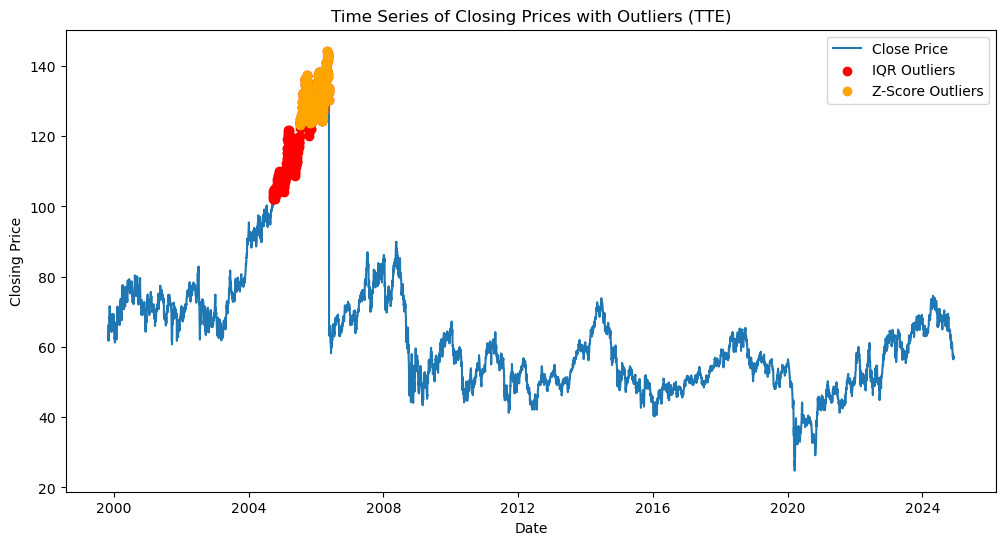

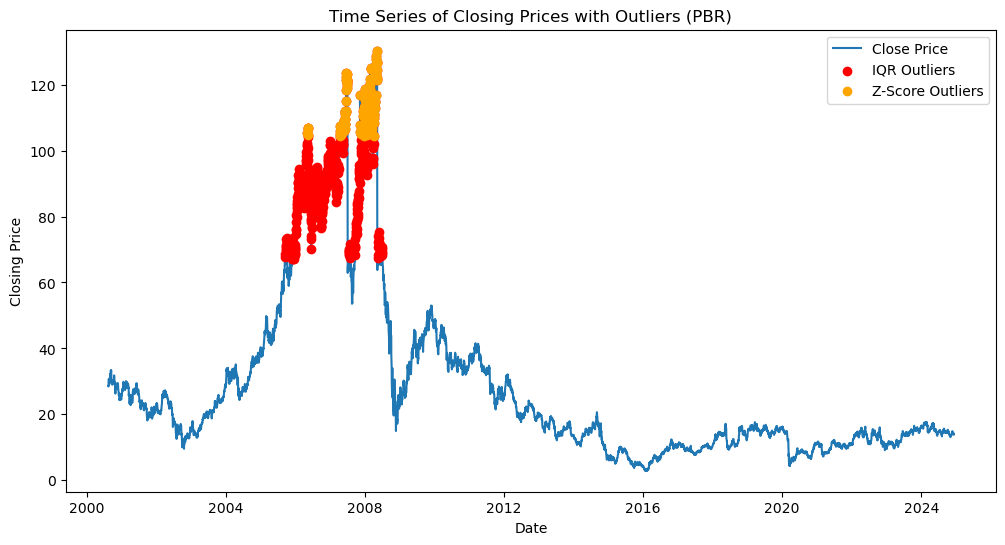

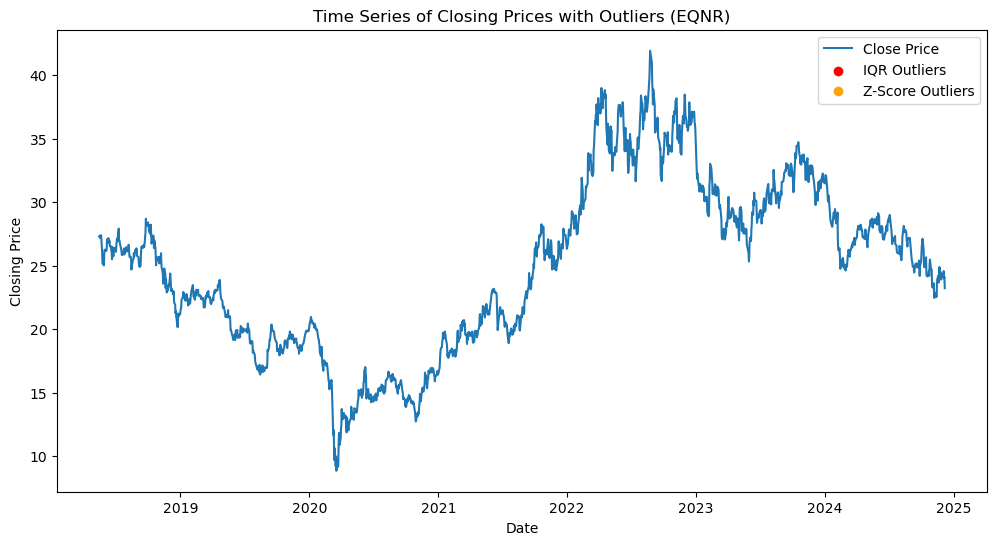

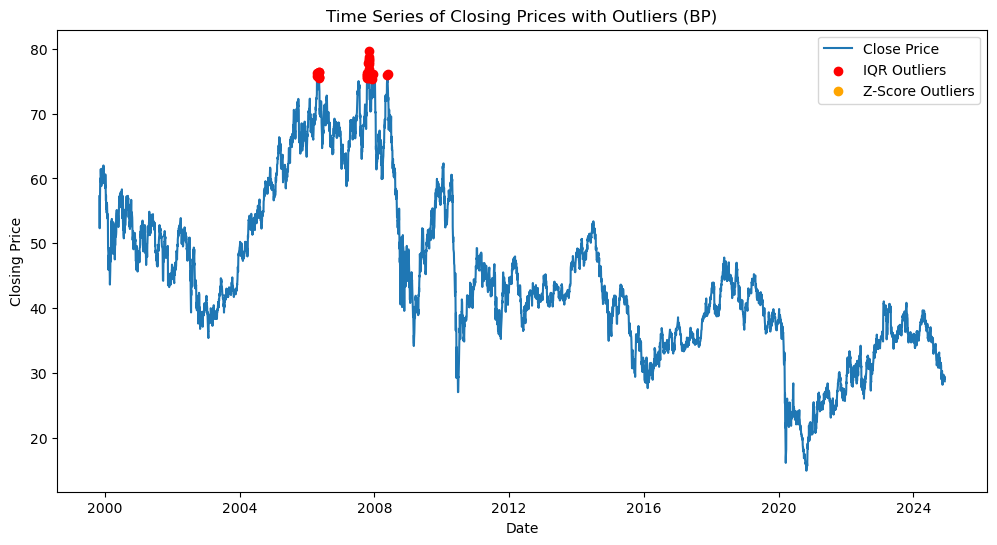

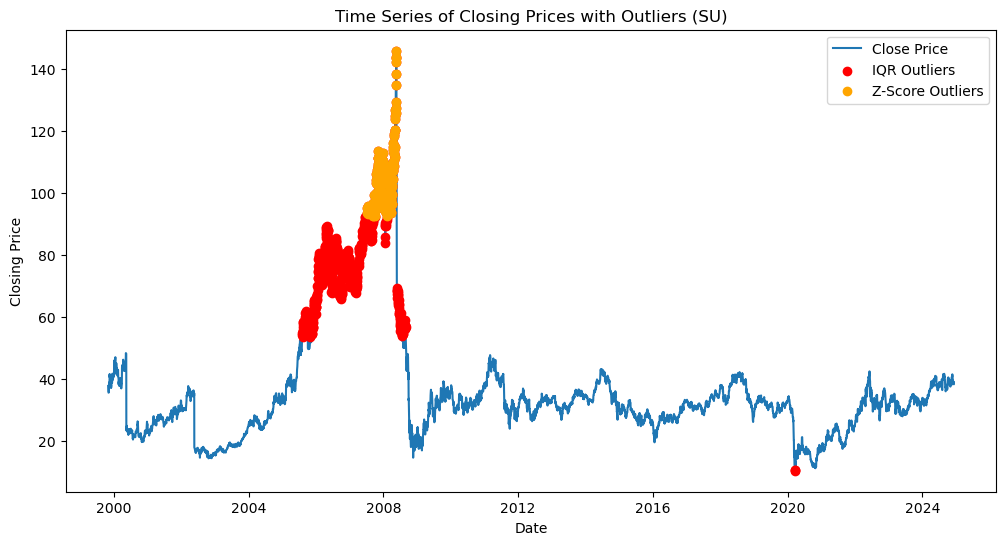

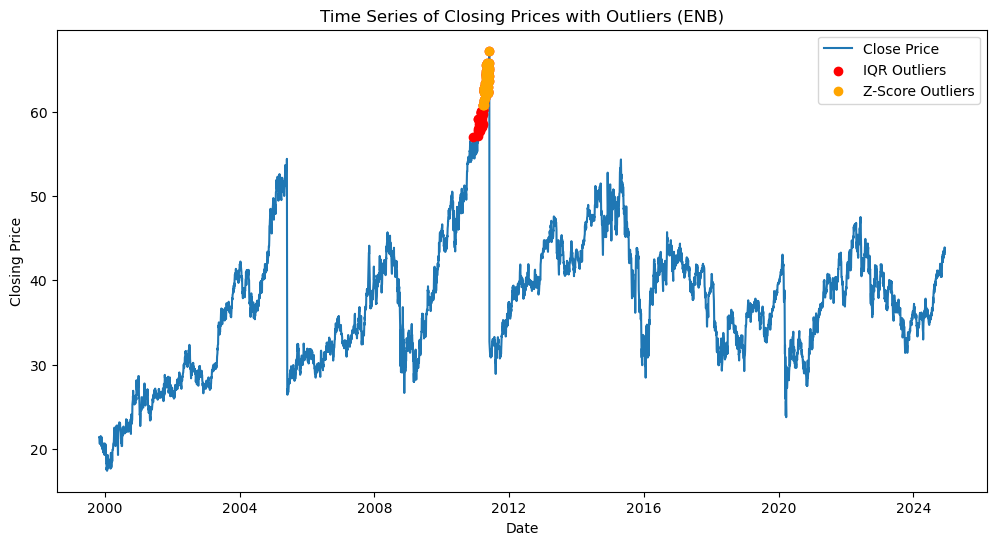

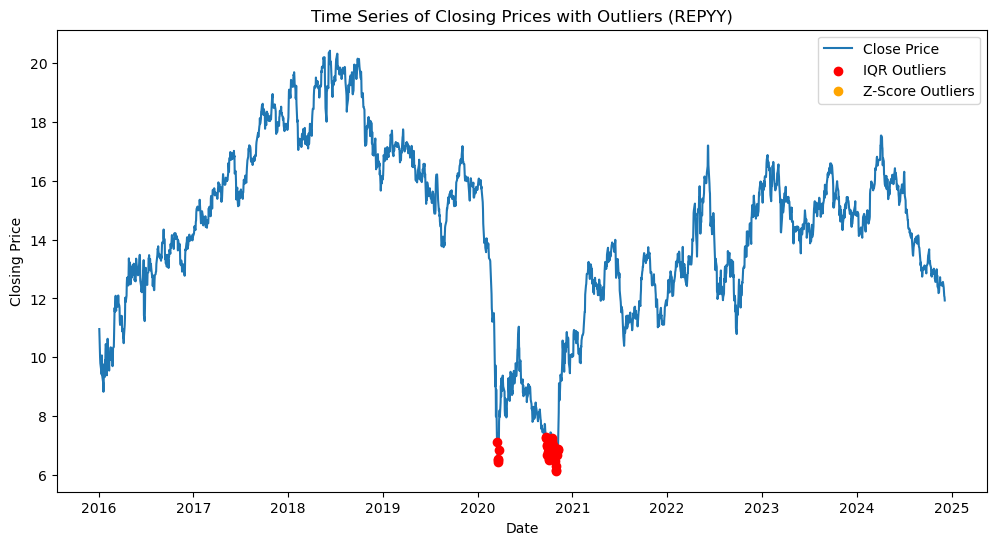

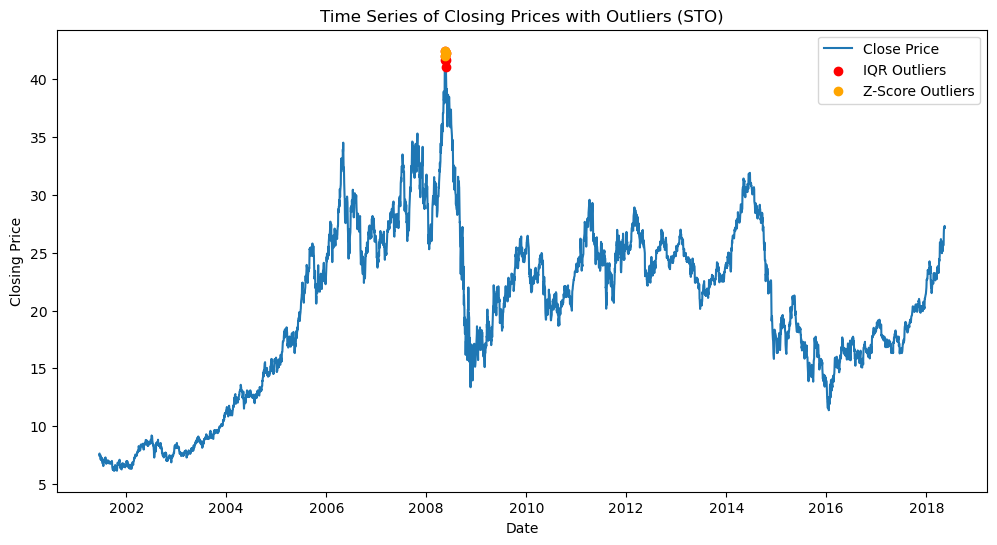

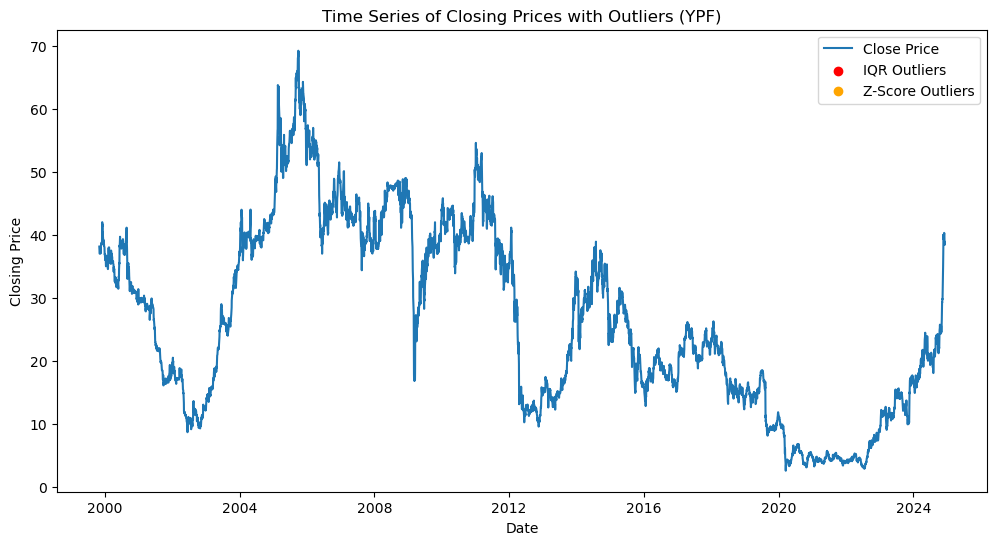

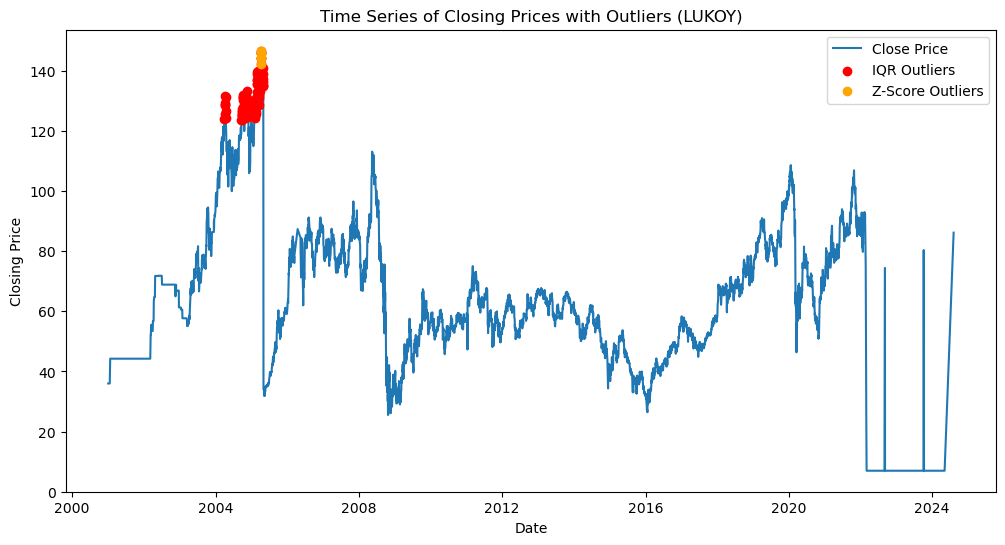

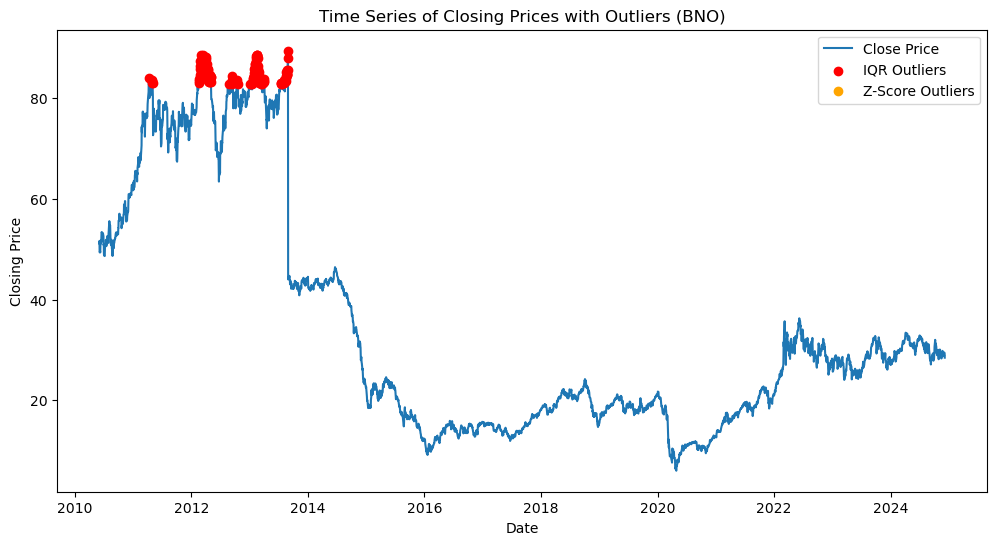

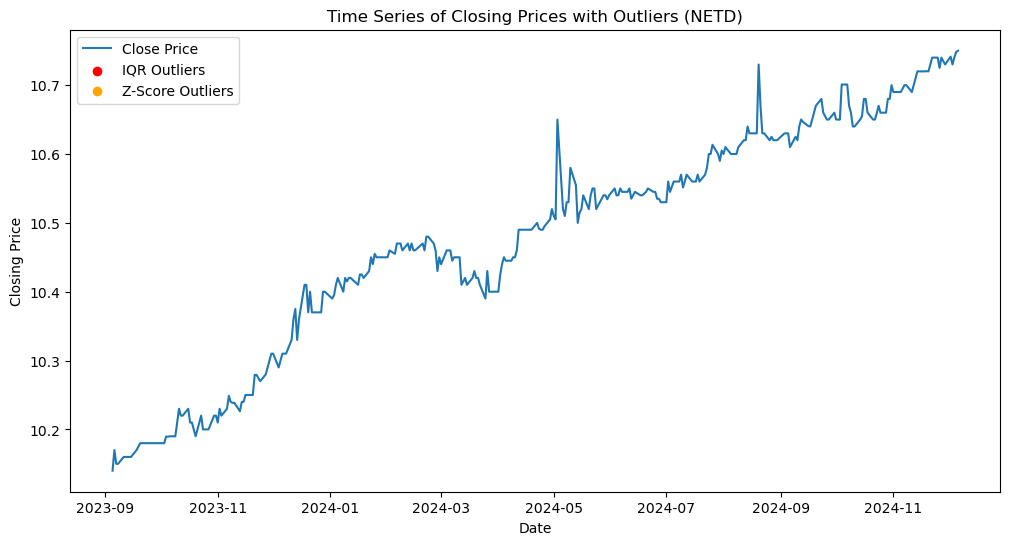

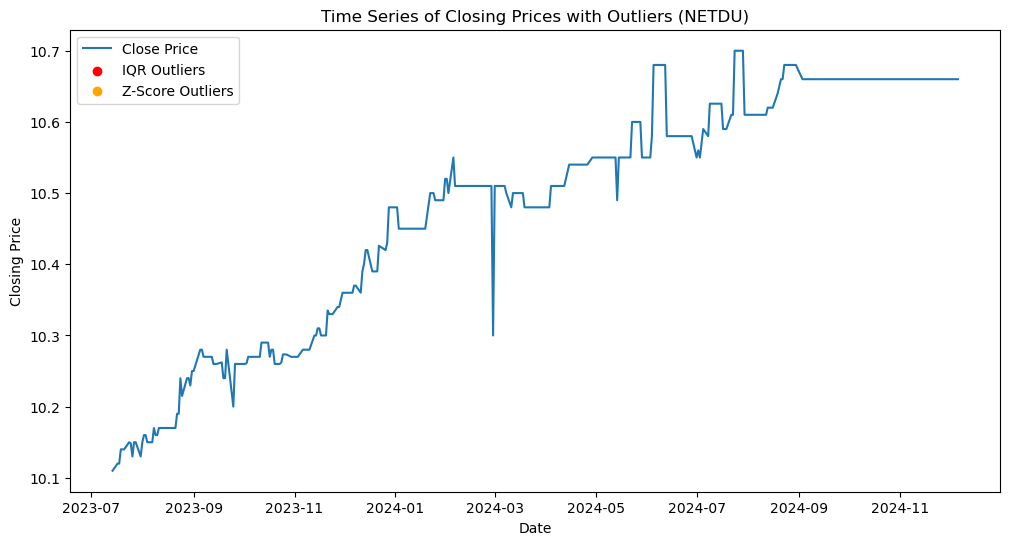

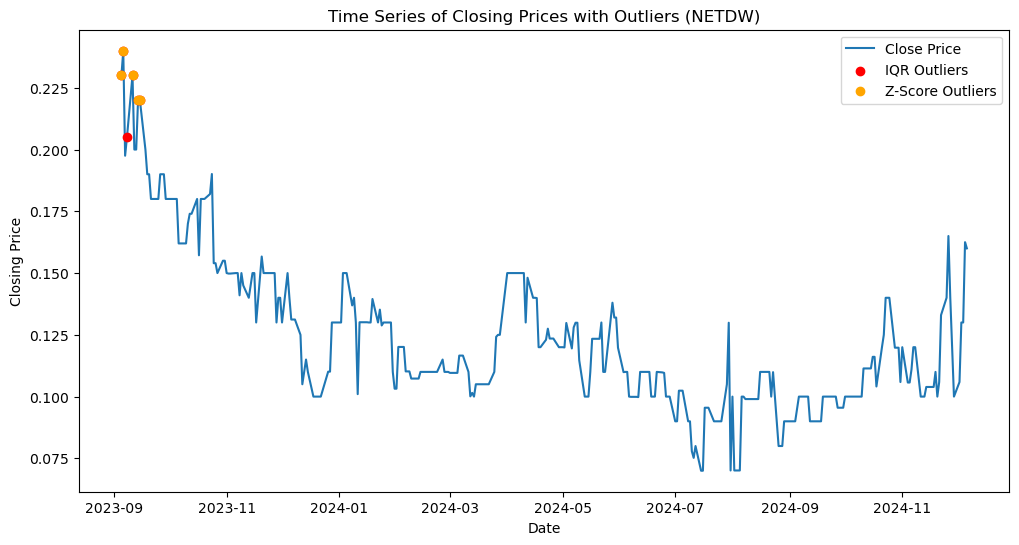

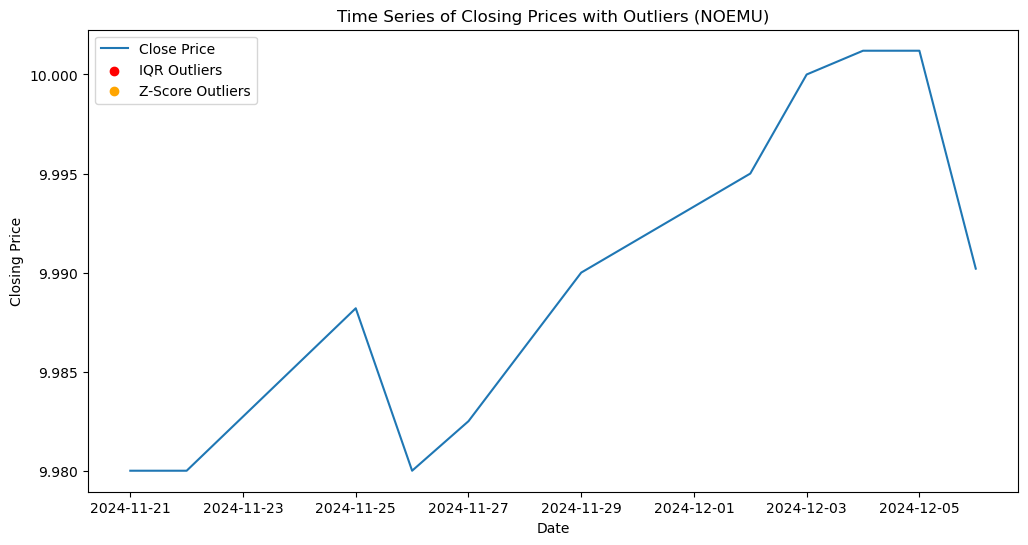

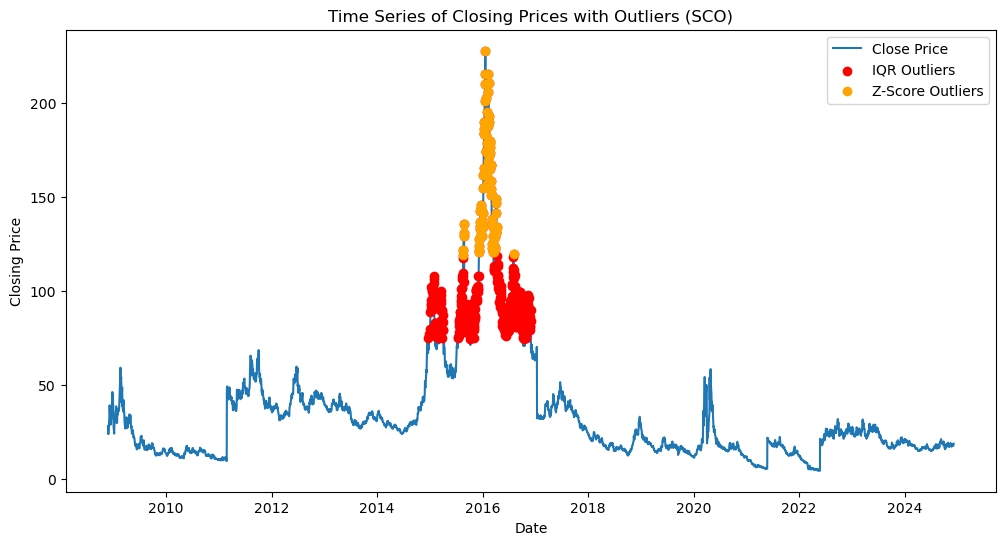

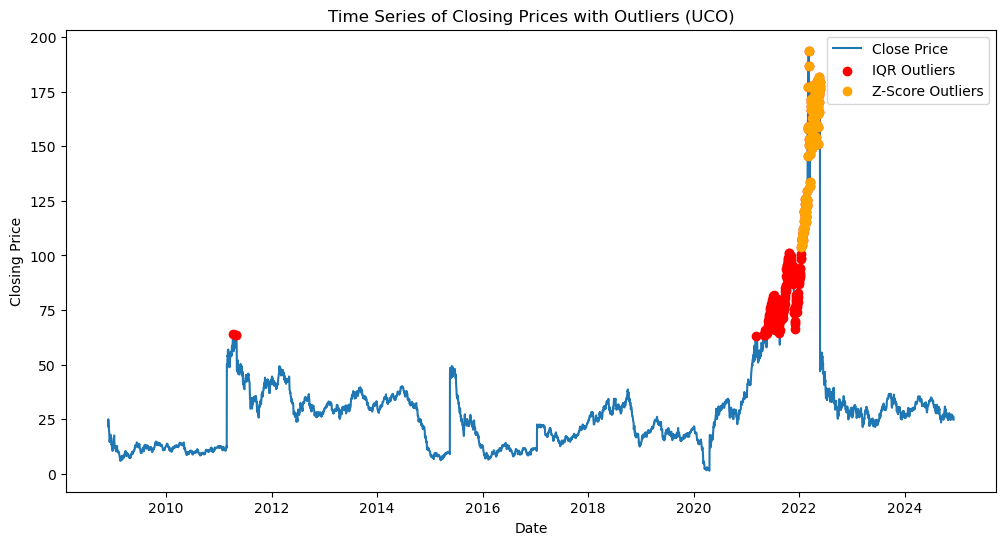

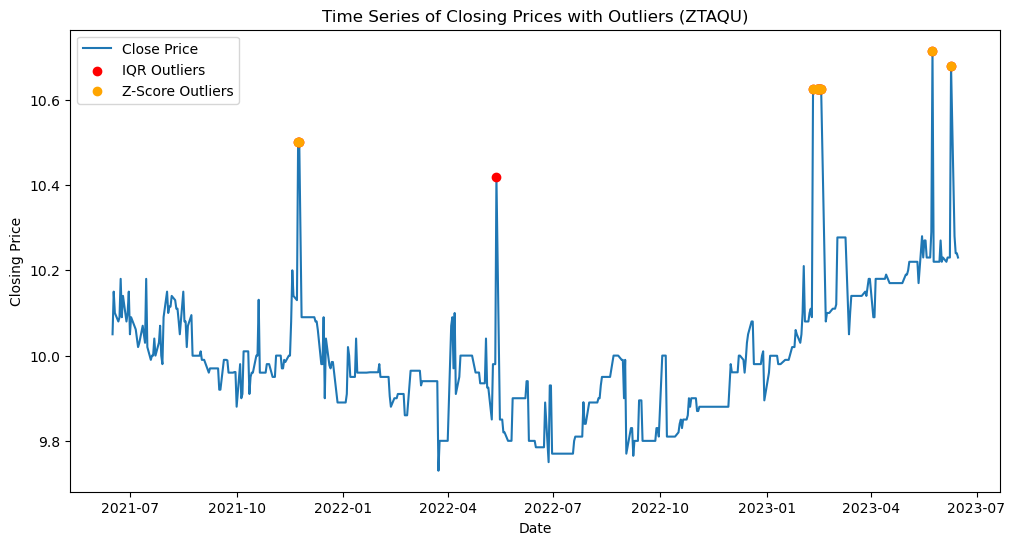

   Ticker  IQR Outliers  Z-Score Outliers
0     XOM             0                 0
1     CVX            69                 5
2     EOG            49                25
3    SHEL             0                 0
4     TTE           421               212
5     PBR           613               136
6    EQNR             0                 0
7      BP            31                 0
8      SU           739               176
9     ENB            88                46
10  REPYY            37                 0
11    STO             6                 3
12    YPF             0                 0
13  LUKOY           120                 6
14    BNO           132                 0
15   NETD             0                 0
16  NETDU             0                 0
17  NETDW             6                 5
18  NOEMU             0                 0
19    SCO           391                86
20    UCO           267                91
21  ZTAQU            11                10


In [2]:
# Iterate through each ticker
tickers = data['ticker'].unique()

outlier_summary = []

for ticker in tickers:
    ticker_data = data[data['ticker'] == ticker]
    close_prices = ticker_data['4. close']

    # Identify outliers using IQR
    iqr_outliers_values = iqr_outliers(close_prices)

    # Identify outliers using Z-Scores
    zscore_outliers_values = zscore_outliers(close_prices, threshold=3)

    # Append the summary for this ticker
    outlier_summary.append({
        'Ticker': ticker,
        'IQR Outliers': len(iqr_outliers_values),
        'Z-Score Outliers': len(zscore_outliers_values)
    })

    # Plot time series with outliers for this ticker
    plt.figure(figsize=(12, 6))
    plt.plot(ticker_data.index, close_prices, label='Close Price')
    plt.scatter(iqr_outliers_values.index, iqr_outliers_values, color='red', label='IQR Outliers', zorder=5)
    plt.scatter(zscore_outliers_values.index, zscore_outliers_values, color='orange', label='Z-Score Outliers', zorder=5)
    plt.title(f"Time Series of Closing Prices with Outliers ({ticker})")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.show()

# Convert outlier summary to a DataFrame and display
outlier_summary_df = pd.DataFrame(outlier_summary)
print(outlier_summary_df)

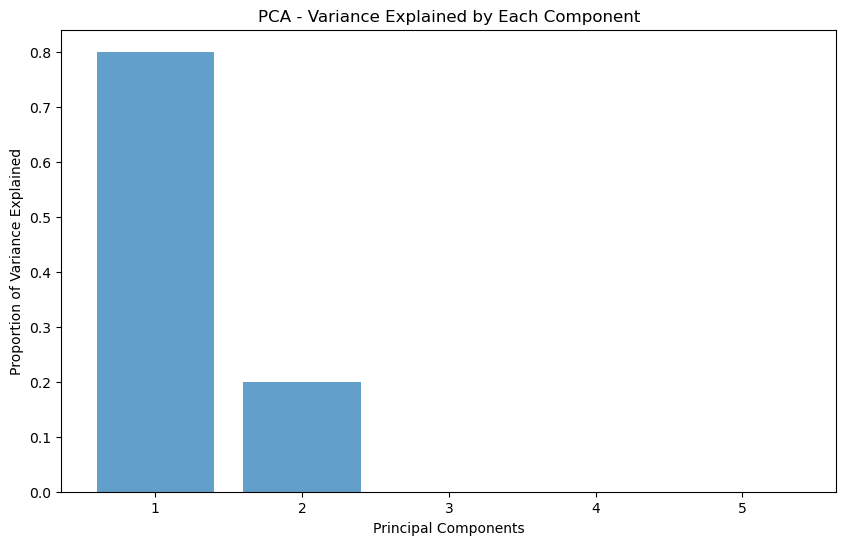

Cumulative Explained Variance:
PC 1: 80.05%
PC 2: 99.98%
PC 3: 99.99%
PC 4: 100.00%
PC 5: 100.00%


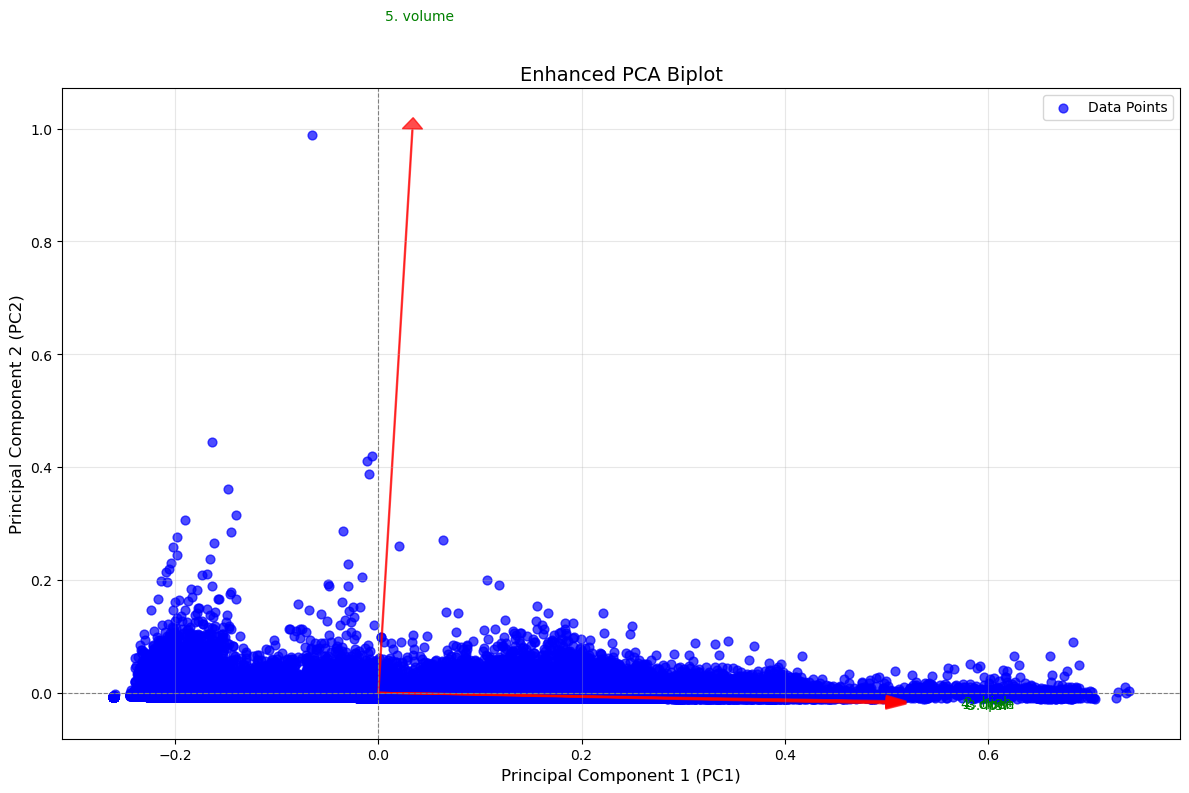

In [3]:
# Data Prep for PCA
# Remove outliers from IQR and Z-Score methods
cleaned_data = pd.DataFrame()

for ticker in tickers:
    ticker_data = data[data['ticker'] == ticker]
    close_prices = ticker_data['4. close']

    iqr_outliers_values = iqr_outliers(close_prices)
    zscore_outliers_values = zscore_outliers(close_prices, threshold=3)

    combined_outliers = pd.concat([iqr_outliers_values, zscore_outliers_values]).drop_duplicates()
    filtered_ticker_data = ticker_data[~ticker_data.index.isin(combined_outliers.index)]

    cleaned_data = pd.concat([cleaned_data, filtered_ticker_data])

numeric_columns = cleaned_data.select_dtypes(include=[np.number])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_columns)

# Initialize & fit PCA
pca = PCA()
pca.fit(scaled_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('PCA - Variance Explained by Each Component')
plt.show()

cumulative_explained_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:")
for i, cumulative_variance in enumerate(cumulative_explained_variance):
    print(f"PC {i+1}: {cumulative_variance:.2%}")

def enhanced_biplot(scores, coeffs, labels=None):
    xs = scores[:, 0]
    ys = scores[:, 1]
    n = coeffs.shape[0]
    
    # Scale the scatter points
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    
    # Scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(xs * scalex, ys * scaley, c='blue', alpha=0.7, s=40, label="Data Points")
    
    # Arrows and labels for variables
    for i in range(n):
        plt.arrow(0, 0, coeffs[i, 0], coeffs[i, 1], color='red', alpha=0.7, head_width=0.02, head_length=0.02)
        if labels is None:
            plt.text(coeffs[i, 0] * 1.2, coeffs[i, 1] * 1.2, f"Var{i+1}", color='green', fontsize=10, ha='center', va='center')
        else:
            plt.text(coeffs[i, 0] * 1.2, coeffs[i, 1] * 1.2, labels[i], color='green', fontsize=10, ha='center', va='center')
    
    # Enhancements
    plt.axhline(0, color='grey', lw=0.8, linestyle='--')
    plt.axvline(0, color='grey', lw=0.8, linestyle='--')
    plt.grid(alpha=0.3)
    plt.xlabel("Principal Component 1 (PC1)", fontsize=12)
    plt.ylabel("Principal Component 2 (PC2)", fontsize=12)
    plt.title("Enhanced PCA Biplot", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

pca_scores = pca.transform(scaled_data)
enhanced_biplot(pca_scores, pca.components_.T, labels=numeric_columns.columns)

Feature Contributions to Principal Components:
           PC1 Contribution  PC2 Contribution
1. open            0.499723          0.016668
2. high            0.499728          0.014516
3. low             0.499699          0.019097
4. close           0.499724          0.016816
5. volume          0.033549          0.999432


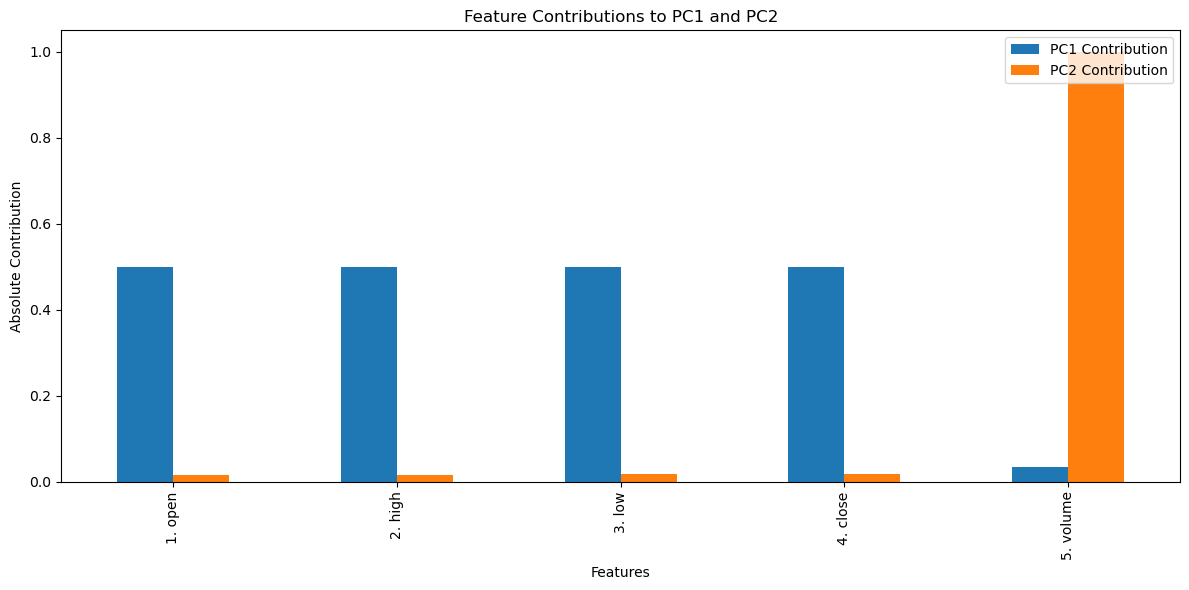

In [4]:
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=numeric_columns.columns
)

pc1_importance = pca_loadings['PC1'].abs().sort_values(ascending=False)
pc2_importance = pca_loadings['PC2'].abs().sort_values(ascending=False)

feature_importance = pd.DataFrame({
    "PC1 Contribution": pc1_importance,
    "PC2 Contribution": pc2_importance
})

# Feature contributions to PC1 and PC2
print("Feature Contributions to Principal Components:")
print(feature_importance)

feature_importance.plot(kind='bar', figsize=(12, 6), title='Feature Contributions to PC1 and PC2')
plt.xlabel("Features")
plt.ylabel("Absolute Contribution")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Momentum

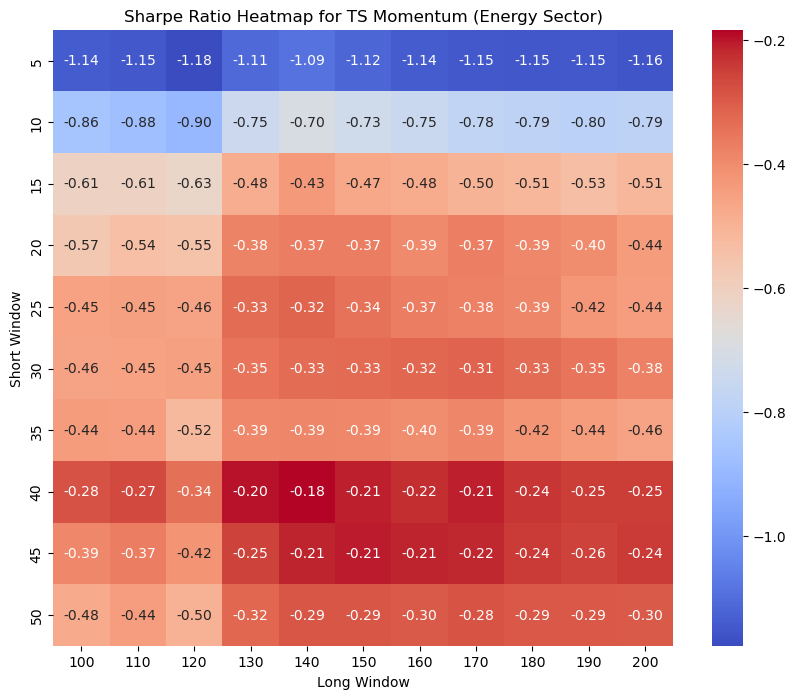

In [5]:
flat_data = data.reset_index()

adj_close = flat_data[flat_data['ticker'] == 'XOM']['4. close']

stocks_close = flat_data.pivot(index='date', columns='ticker', values='4. close')
stocks_ret = stocks_close.pct_change()

# Time-Series and Cross-Sectional Momentum Signal Generation
def generate_signals(ret, short_window, long_window, strategy_type):
    short_ma = ret.rolling(short_window, min_periods=1).mean()
    long_ma = ret.rolling(long_window, min_periods=1).mean()

    if strategy_type == 'TS':
        signal = np.sqrt(short_window) * (short_ma - long_ma)
        signal = signal / ret.rolling(long_window, min_periods=1).std()
        port = np.tanh(signal)

    elif strategy_type == 'XS':
        signal = short_ma - long_ma
        ranked = signal.rank(axis=1)
        port = ranked.subtract(ranked.mean(axis=1), axis=0)

    port = port.div(port.abs().sum(axis=1), axis=0)
    return signal, port

def compute_turnover(port):
    to = (port.fillna(0) - port.shift().fillna(0)).abs().sum(axis=1)
    return to

def compute_sharpe_ratio(rets):
    mean_rets = rets.mean() * 252  # Annualized mean return
    vol = rets.std() * np.sqrt(252)  # Annualized volatility
    sharpe_ratio = mean_rets / vol
    return sharpe_ratio

# Define rolling window ranges
short_window_range = range(5, 51, 5)
long_window_range = range(100, 201, 10)

sharpe_ratios = pd.DataFrame(index=short_window_range, columns=long_window_range)

# Calculate Sharpe ratios for each short and long window combination
for short_window in short_window_range:
    for long_window in long_window_range:
        signal, port = generate_signals(stocks_ret, short_window, long_window, 'TS')
        strat_gross_ret = (port.shift() * stocks_ret).sum(axis=1)
        to = compute_turnover(port)
        tcost_bps = 20  # Transaction costs
        strat_net_ret = strat_gross_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)

        sharpe_ratios.loc[short_window, long_window] = compute_sharpe_ratio(strat_net_ret)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sharpe_ratios.astype(float), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Sharpe Ratio Heatmap for TS Momentum (Energy Sector)")
plt.xlabel("Long Window")
plt.ylabel("Short Window")
plt.show()

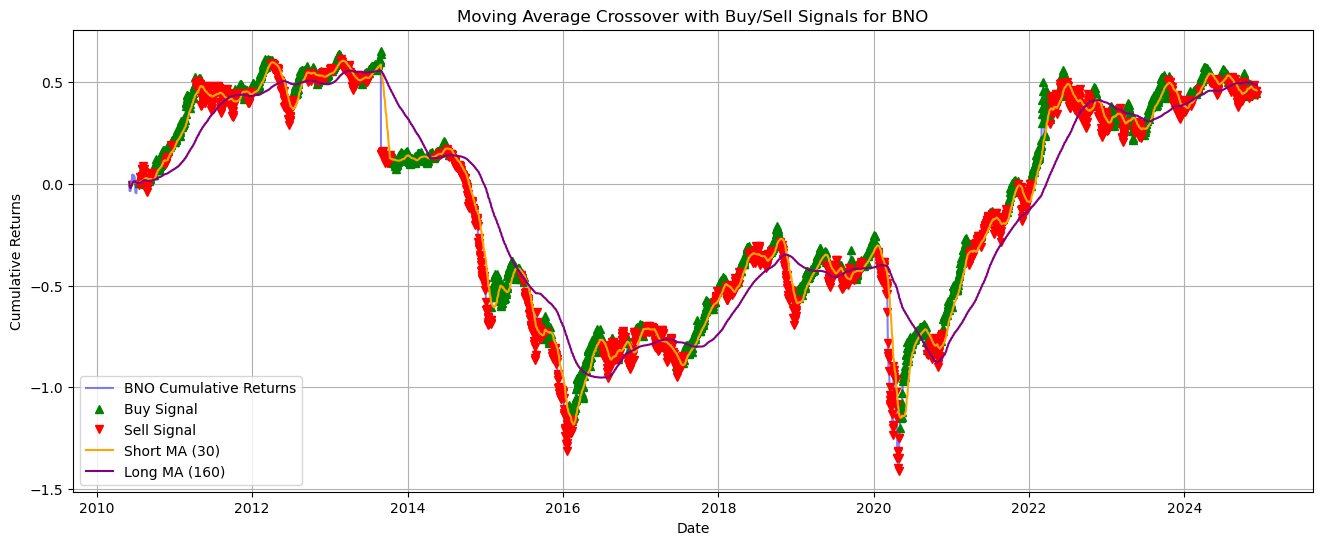

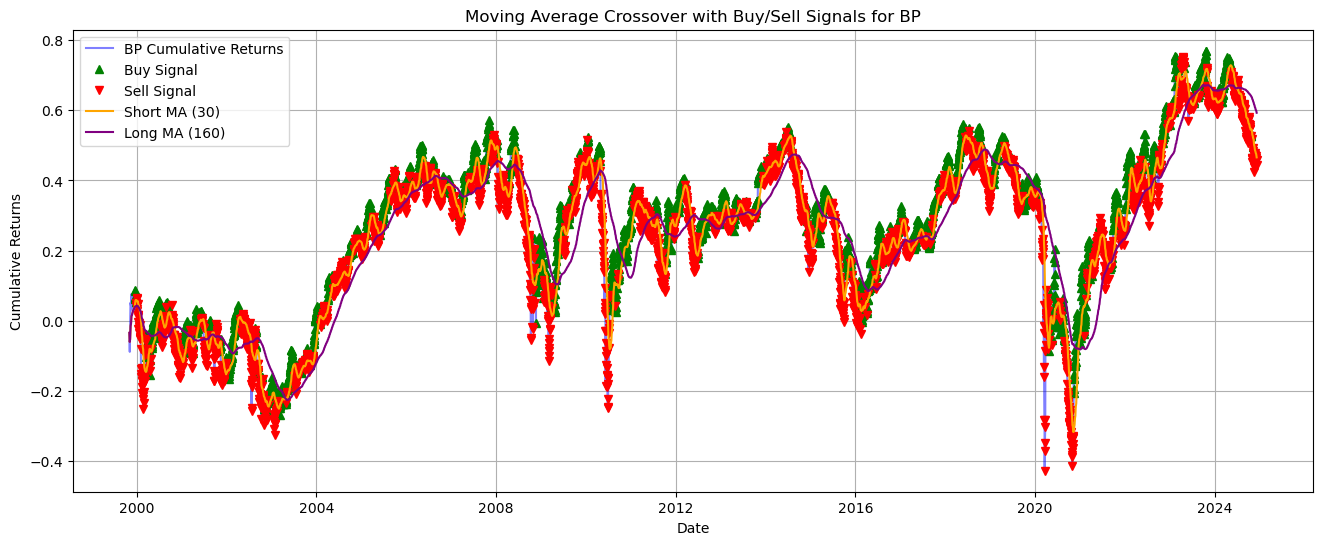

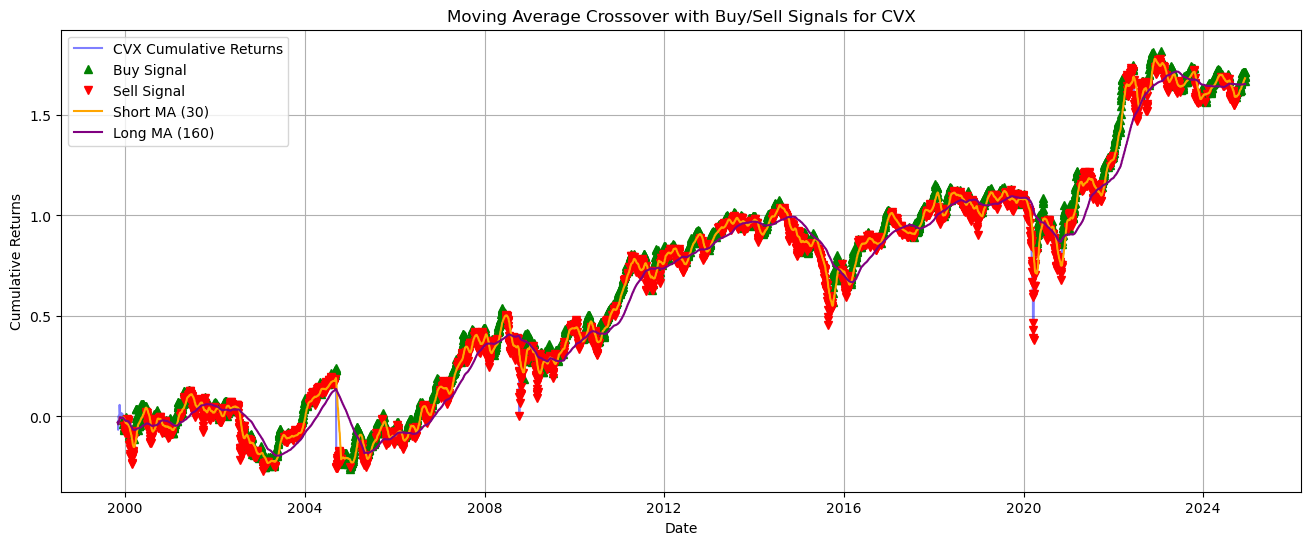

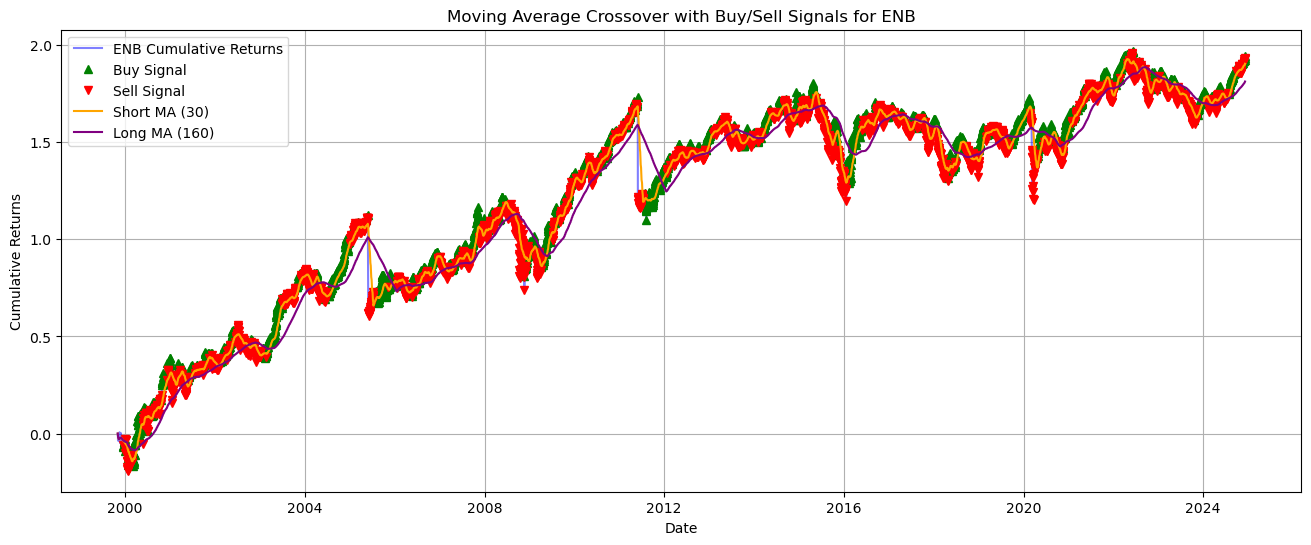

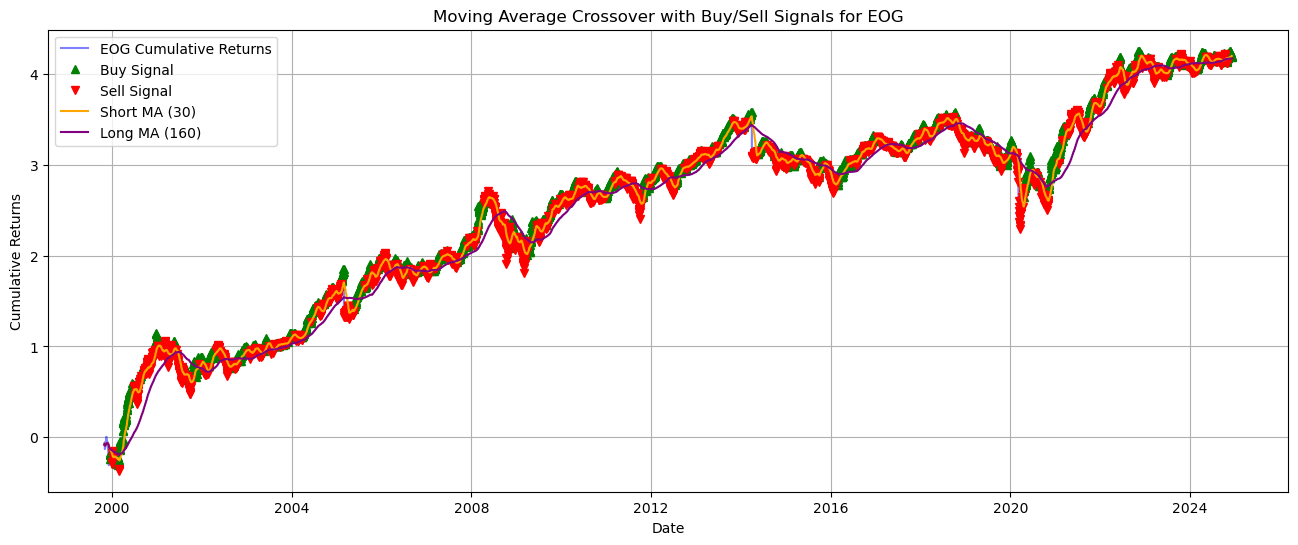

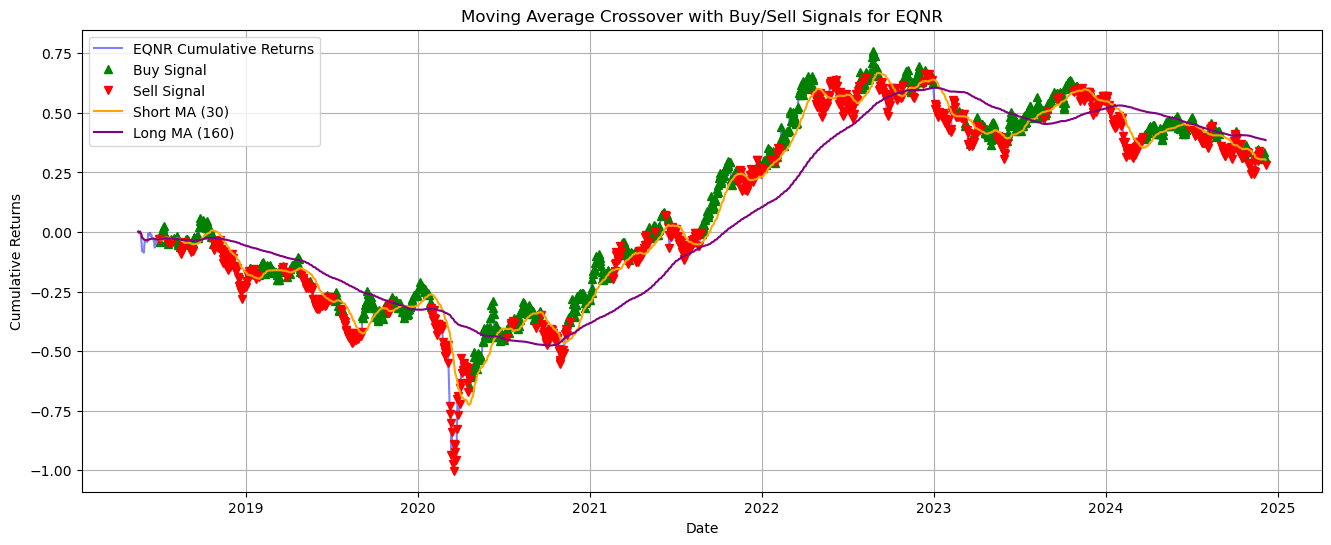

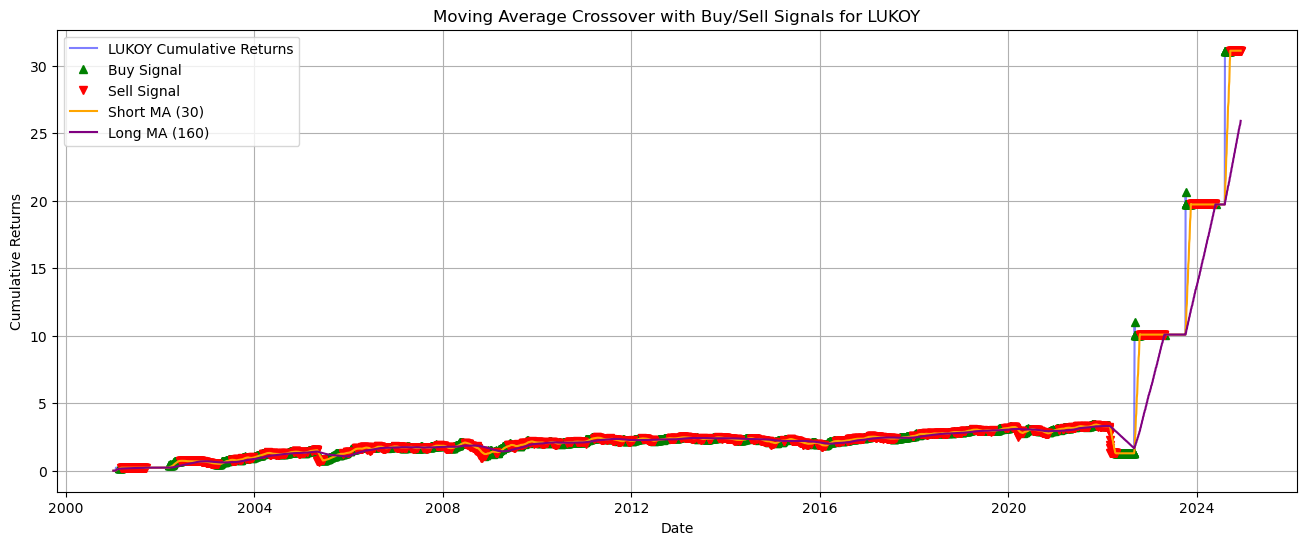

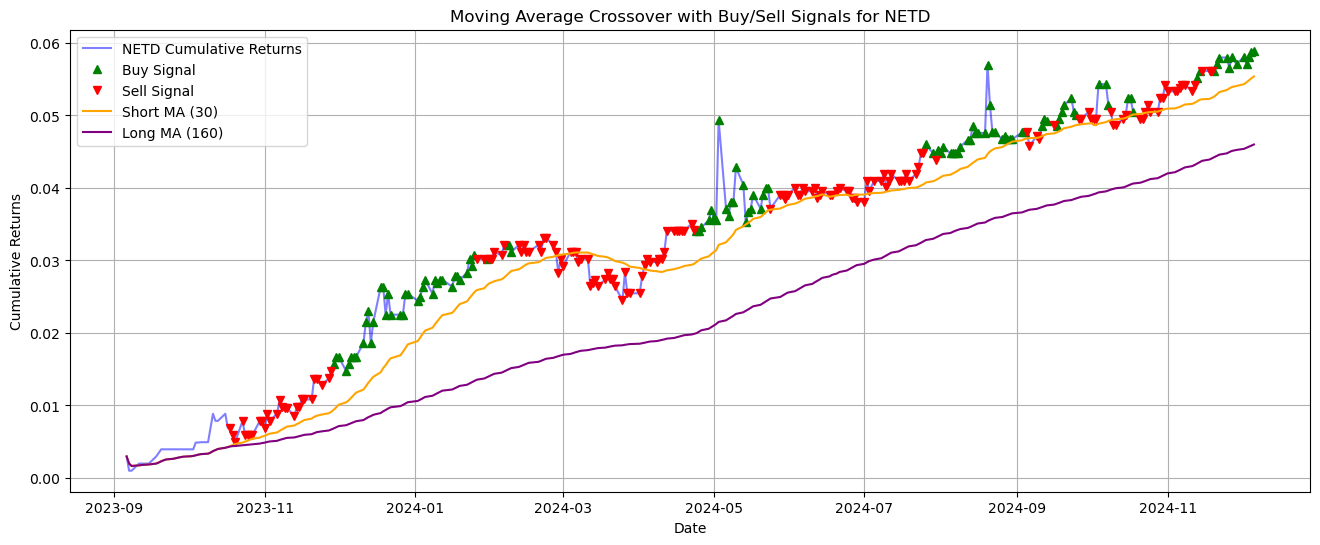

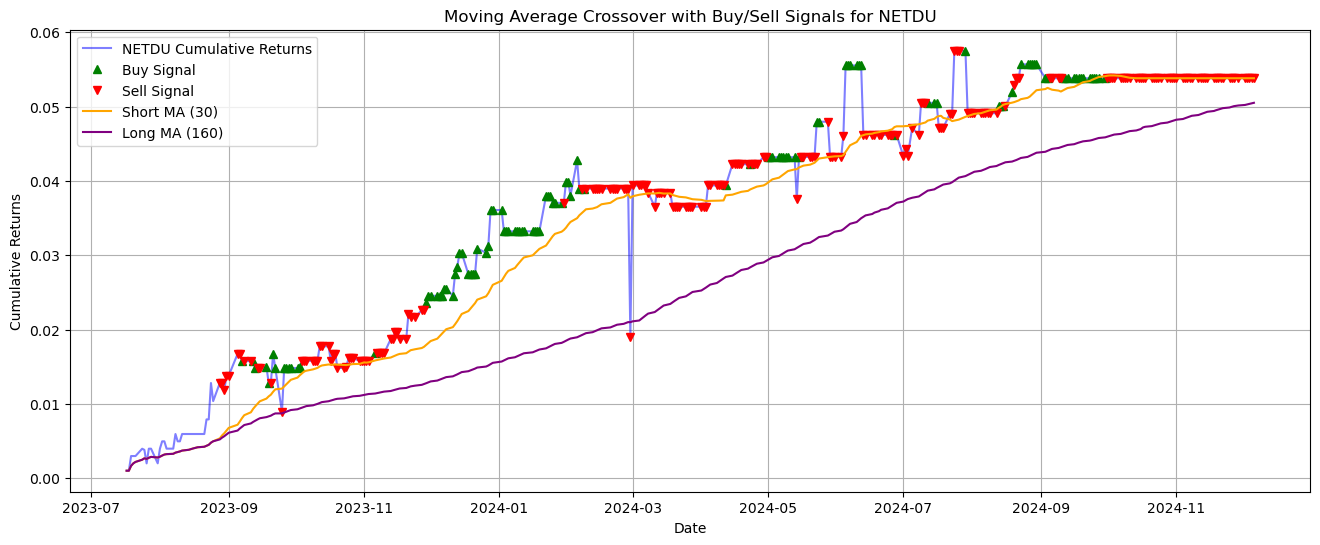

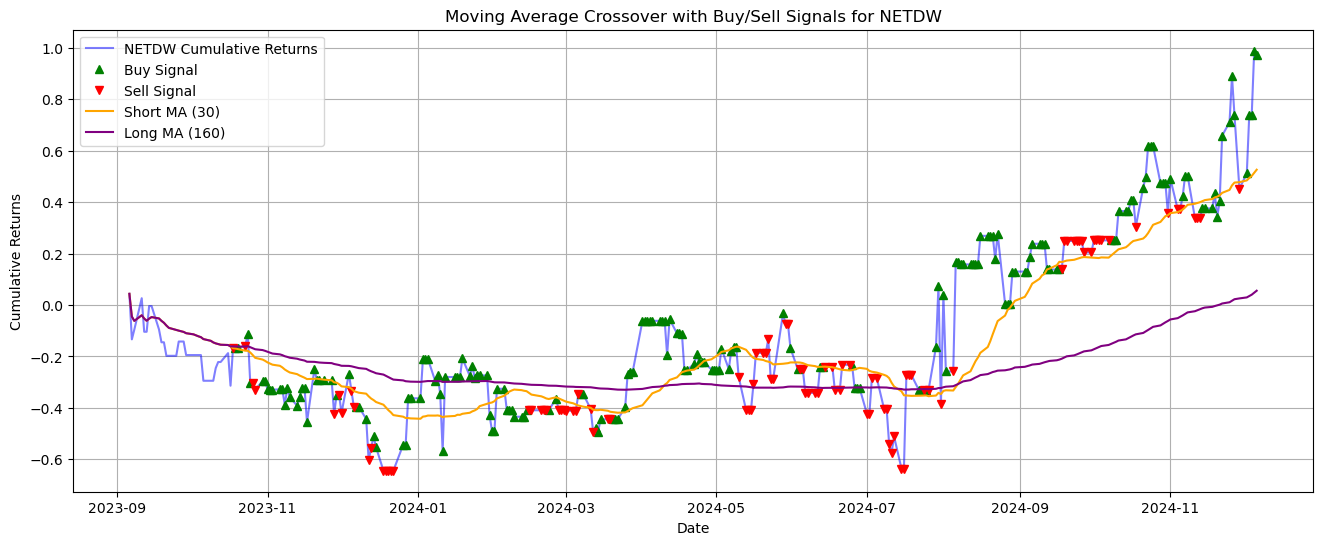

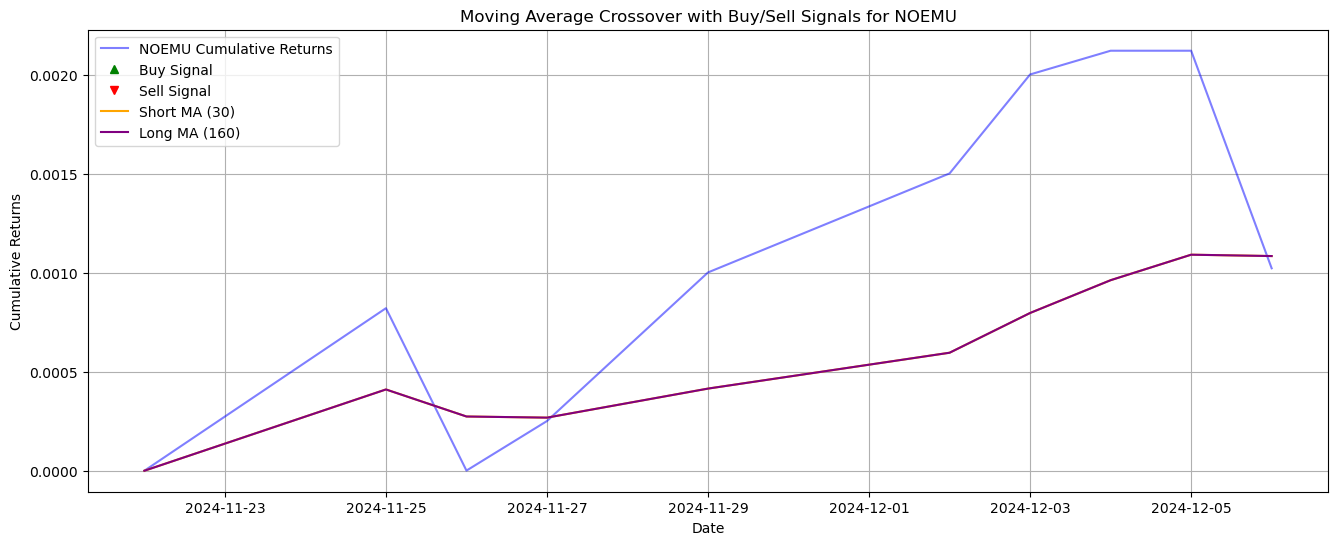

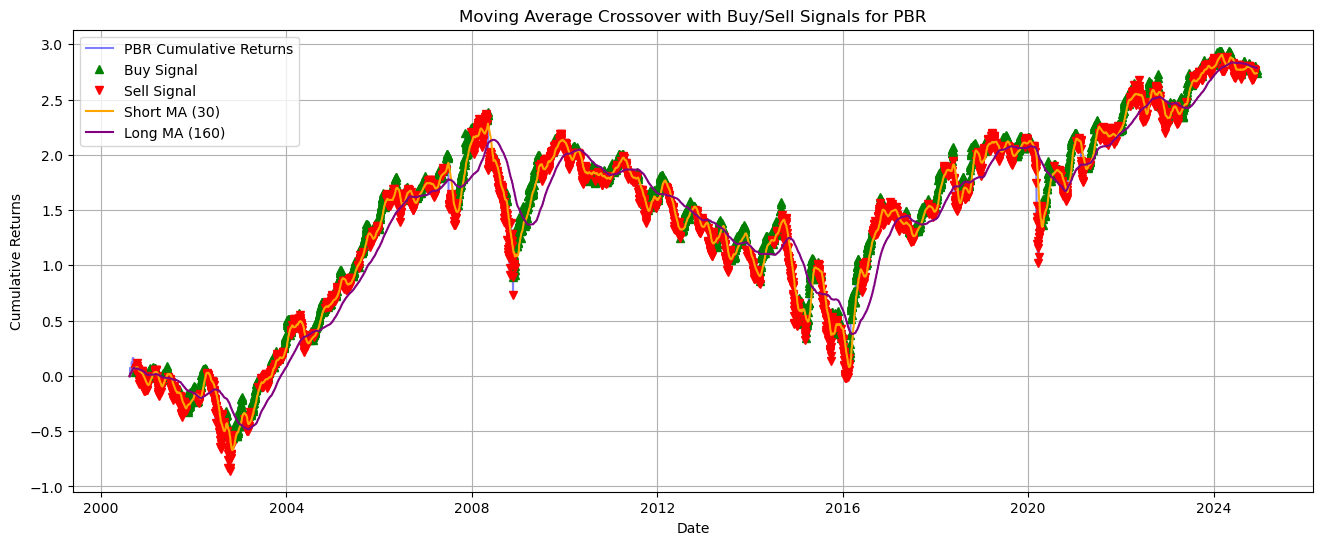

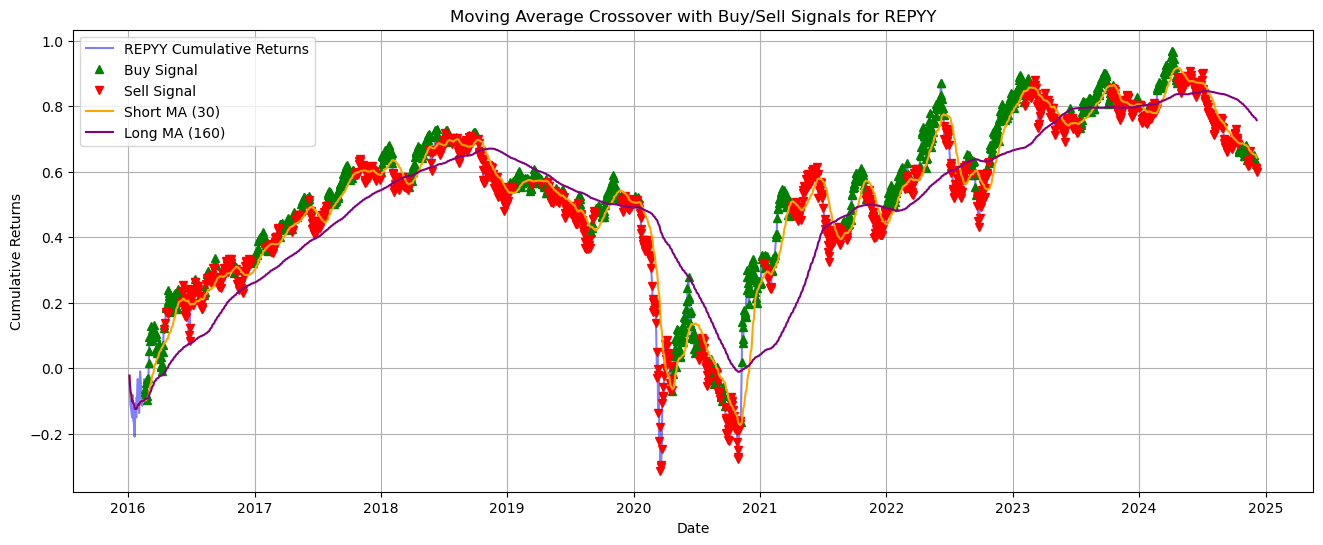

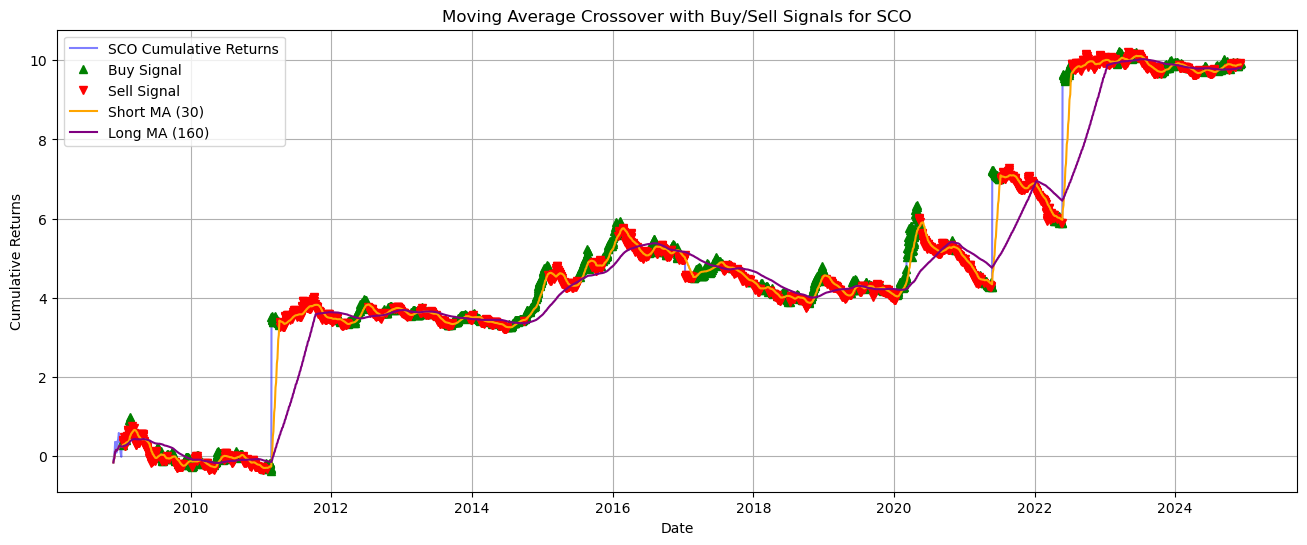

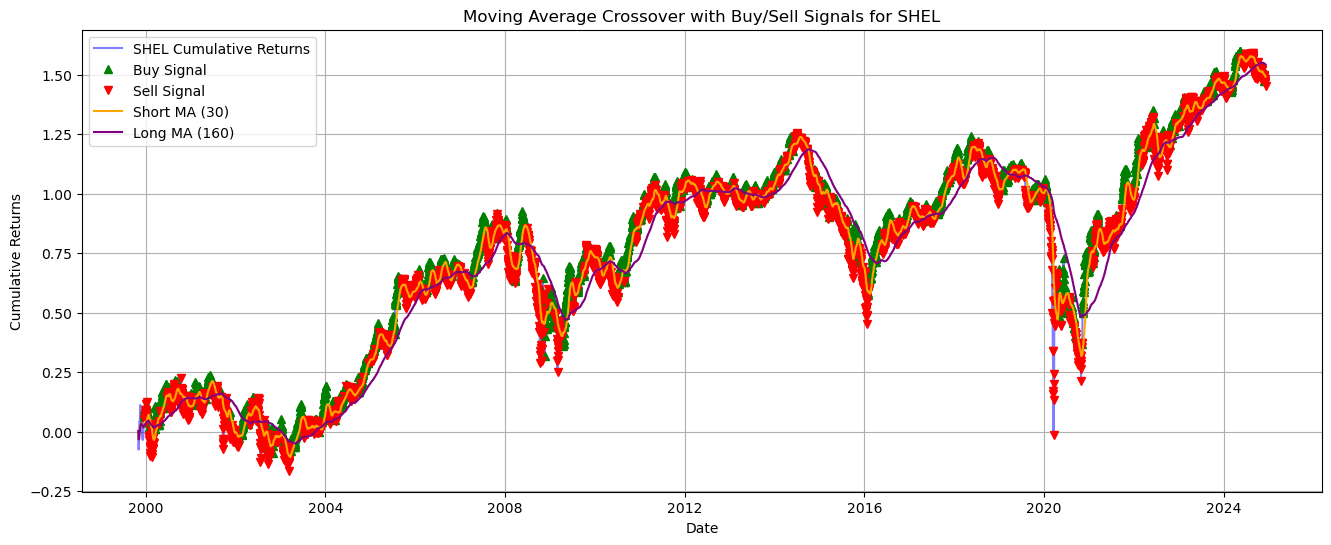

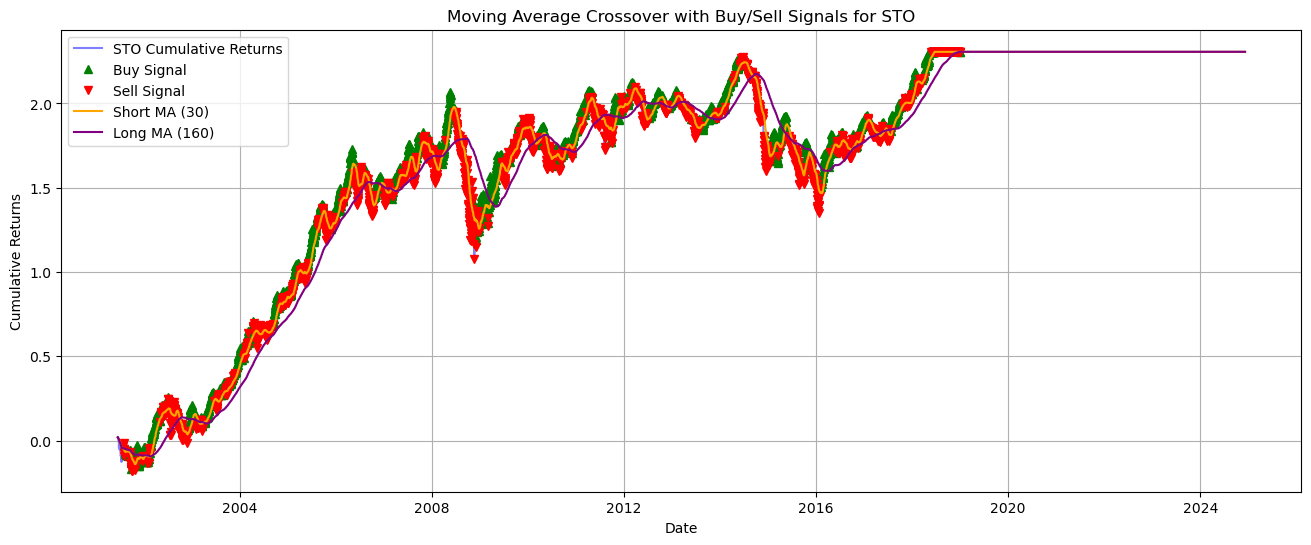

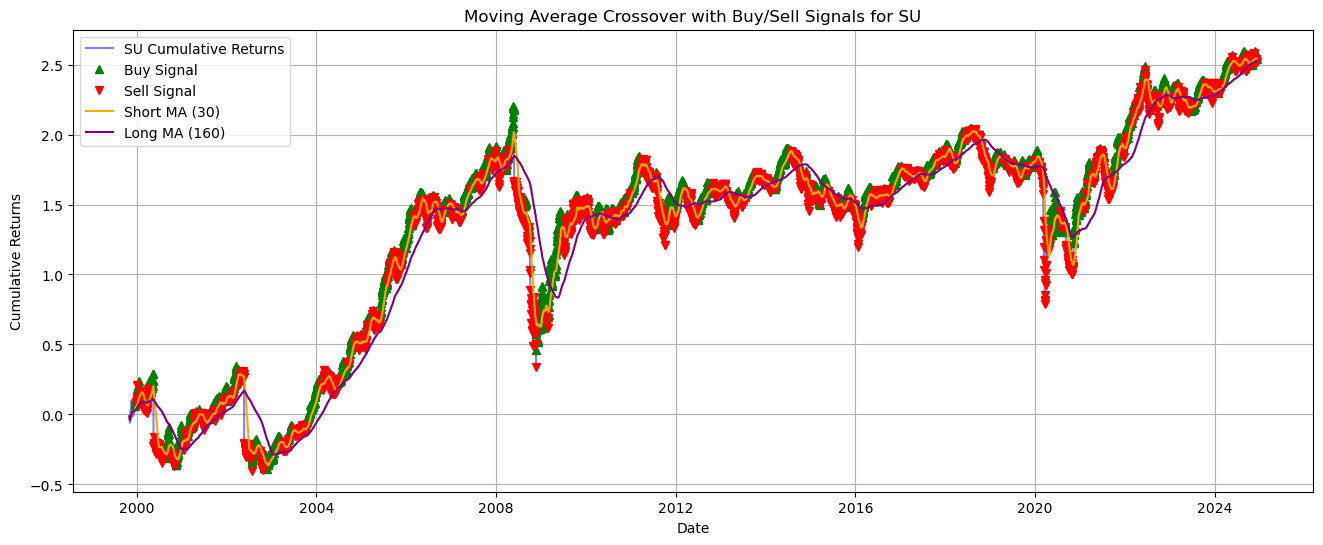

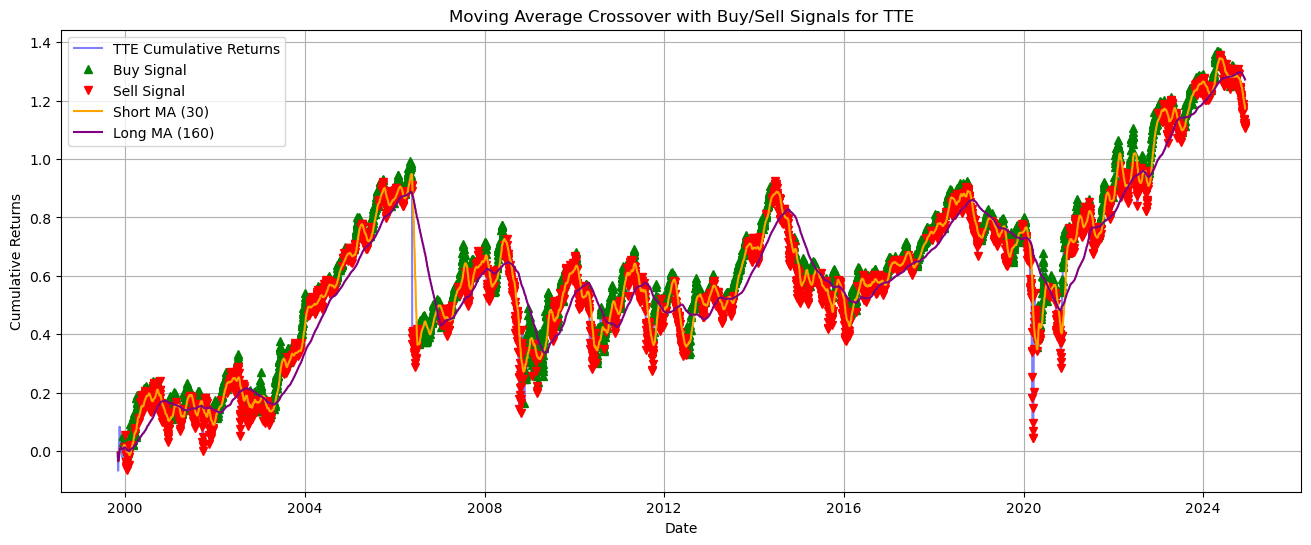

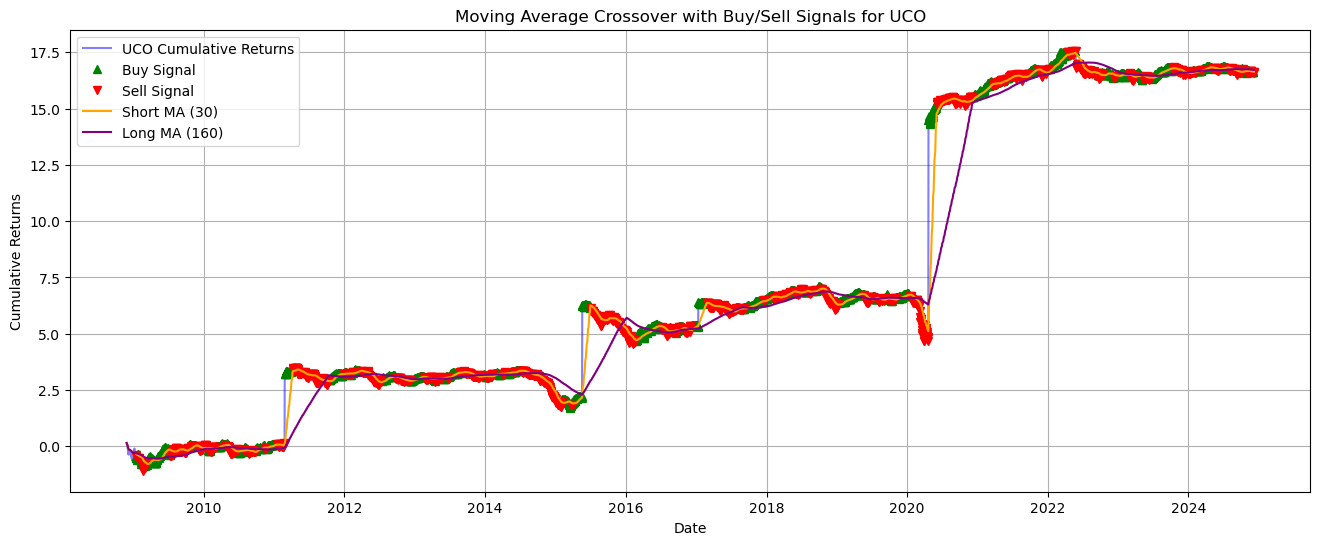

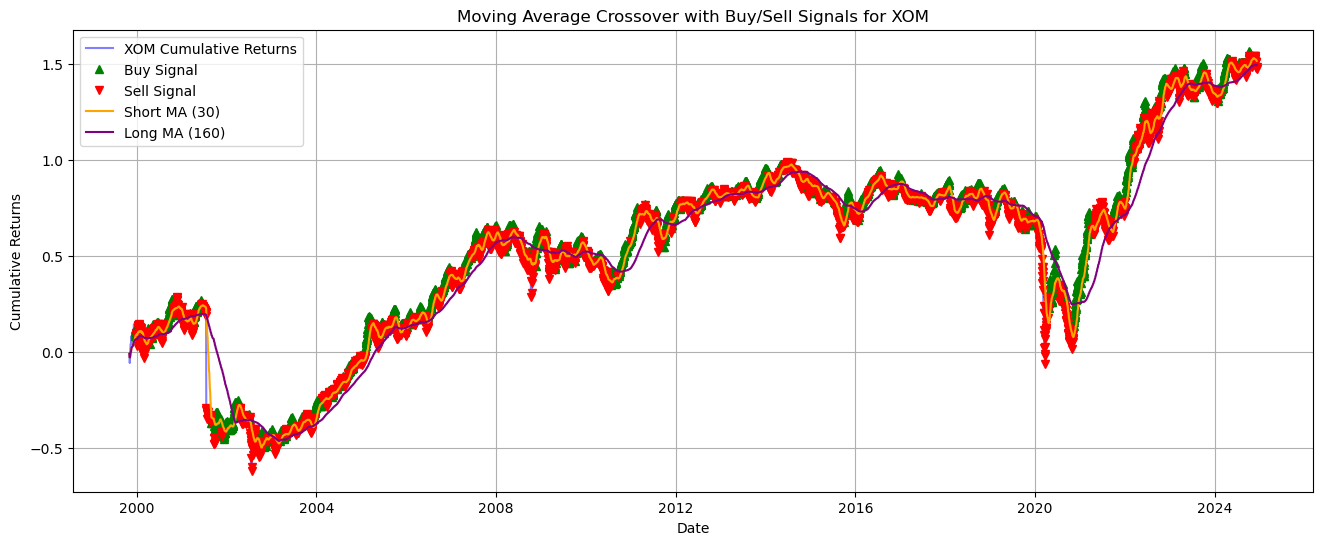

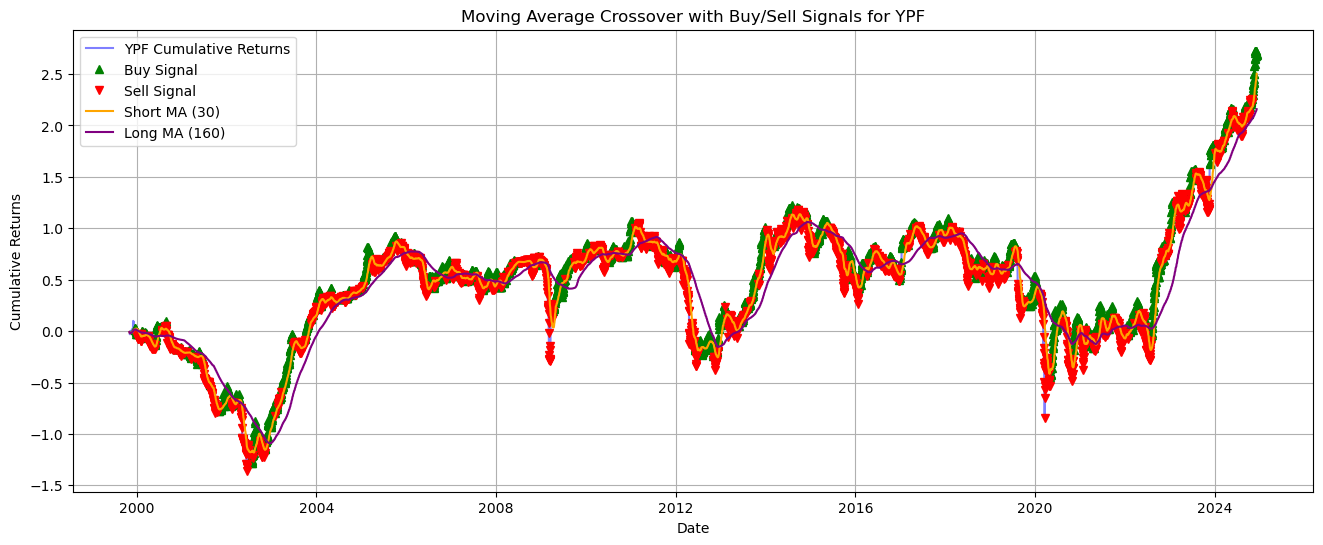

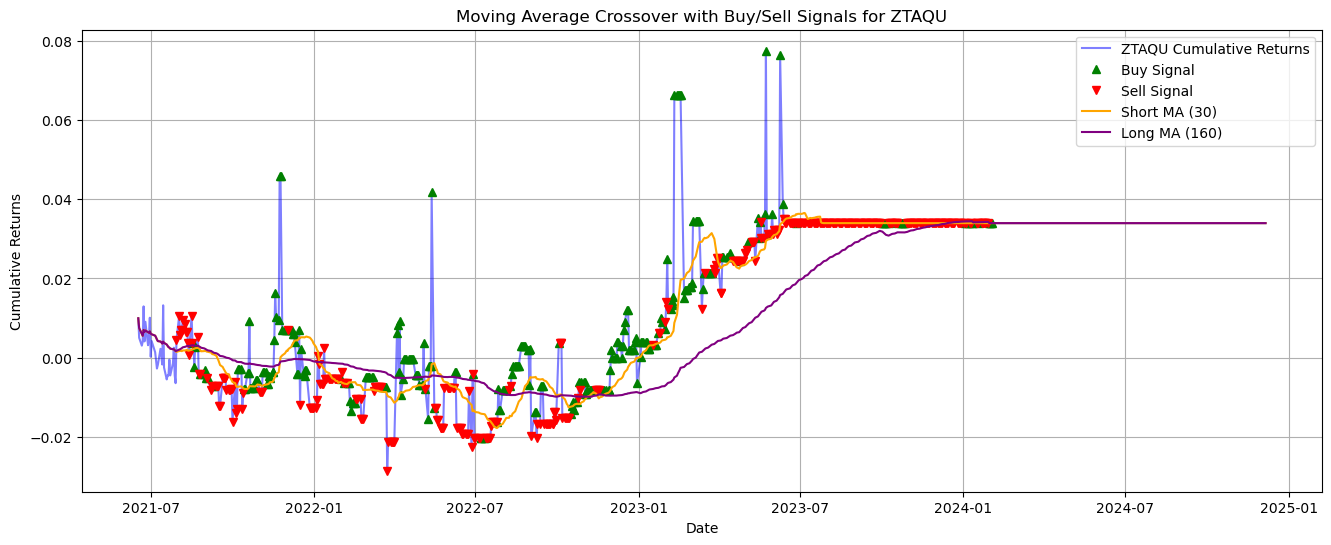

In [6]:
# Signal plotting function
def plot_signals(ret, port, short_window, long_window, stock_name):
    plt.figure(figsize=(16, 6))

    # Calculate cumulative returns
    cum_ret = ret[stock_name].cumsum()
    plt.plot(ret.index, cum_ret, label=f'{stock_name} Cumulative Returns', color='blue', alpha=0.5)
    
    # Plot buy signals
    buy_signals = (port[stock_name] > 0)
    plt.plot(ret.index[buy_signals], cum_ret[buy_signals], '^', markersize=6, color='green', lw=0, label='Buy Signal')

    # Plot sell signals
    sell_signals = (port[stock_name] < 0)
    plt.plot(ret.index[sell_signals], cum_ret[sell_signals], 'v', markersize=6, color='red', lw=0, label='Sell Signal')

    # Plot short and long moving averages of cumulative returns
    short_ma = cum_ret.rolling(short_window, min_periods=1).mean()
    long_ma = cum_ret.rolling(long_window, min_periods=1).mean()
    plt.plot(ret.index, short_ma, label=f'Short MA ({short_window})', color='orange')
    plt.plot(ret.index, long_ma, label=f'Long MA ({long_window})', color='purple')

    plt.title(f'Moving Average Crossover with Buy/Sell Signals for {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()
    plt.show()

# Parameters for the momentum strategy
short_window = 30
long_window = 160

# Generate signals for the full sample period
signal, port = generate_signals(stocks_ret, short_window, long_window, 'TS')

# Plot buy and sell signals for each stock
for stock in stocks_ret.columns:
    plot_signals(stocks_ret, port, short_window, long_window, stock)

The average turnover is 0.2594059730154708
The holding period is 7.709922700510528 days
                             avg       vol    sharpe  hit_rate
ts_strat_ret           -0.124761  0.387428 -0.322022  0.471818
buy_and_hold_benchmark  0.198372  0.341216  0.581369  0.525807


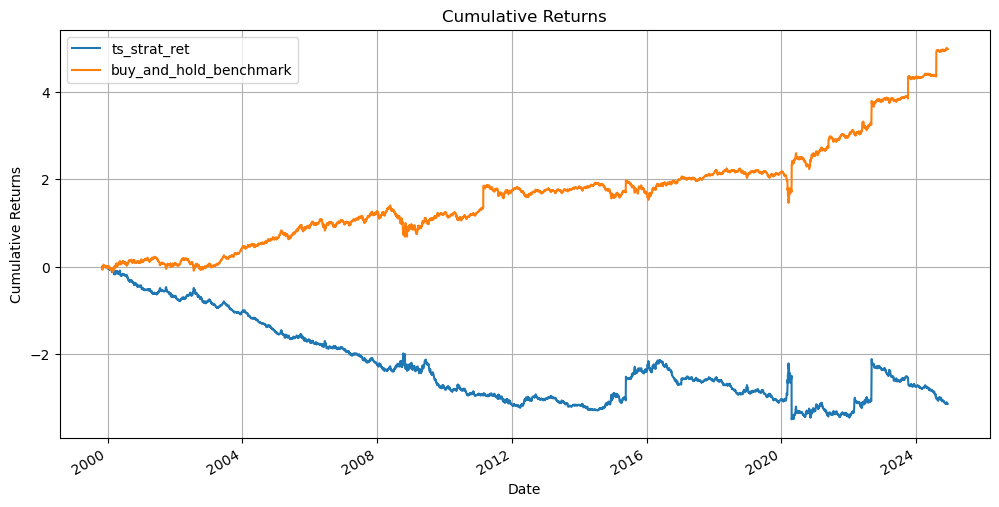

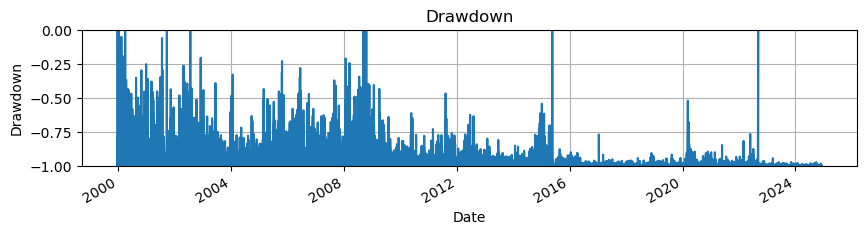

The max drawdown is -inf


In [7]:
# Function to compute drawdown
def drawdown(px):
    """
    Computes the drawdown of a price series.
    """
    return px / px.expanding(min_periods=1).max() - 1

# Evaluate strategy performance
strat_gross_ret = (port.shift() * stocks_ret).sum(axis=1)

# Net of transaction costs returns
to = compute_turnover(port)
tcost_bps = 20  # Transaction costs in basis points
strat_net_ret = strat_gross_ret - (to * tcost_bps * 1e-4)

print(f"The average turnover is {to.mean()}")
print(f"The holding period is {2 / to.mean()} days")

# Full-sample returns and statistics
full_sample_ret = pd.DataFrame({
    'ts_strat_ret': strat_net_ret,
    'buy_and_hold_benchmark': stocks_ret.mean(axis=1)  # Assuming benchmark is an equally-weighted portfolio
})

def compute_stats(rets):
    """
    Compute performance statistics (mean, volatility, Sharpe ratio, hit rate).
    """
    stats = {
        'avg': rets.mean() * 252,
        'vol': rets.std() * np.sqrt(252),
        'sharpe': rets.mean() * 252 / (rets.std() * np.sqrt(252)),
        'hit_rate': (rets > 0).sum() / len(rets)
    }
    return pd.DataFrame(stats)

full_sample_stats = compute_stats(full_sample_ret)
print(full_sample_stats)

# Plot cumulative returns
full_sample_ret.cumsum().plot(figsize=(12, 6))
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid()
plt.show()

# Plot drawdown
dd = drawdown(full_sample_ret['ts_strat_ret'])
plt.figure(figsize=(10, 2))
dd.plot()
plt.ylim(-1, 0)  # Set y-axis limits for drawdown
plt.title("Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid()
plt.show()
print(f"The max drawdown is {dd.min()}")

# Augmented Dickey-Fuller Test for Stationarity

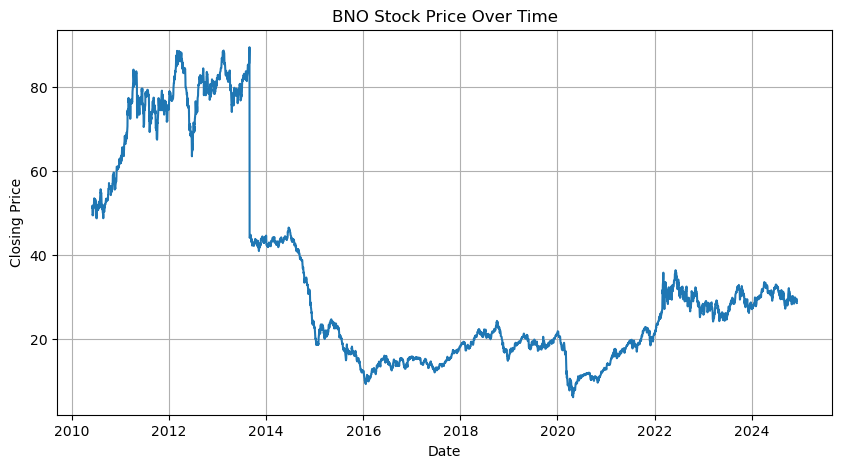

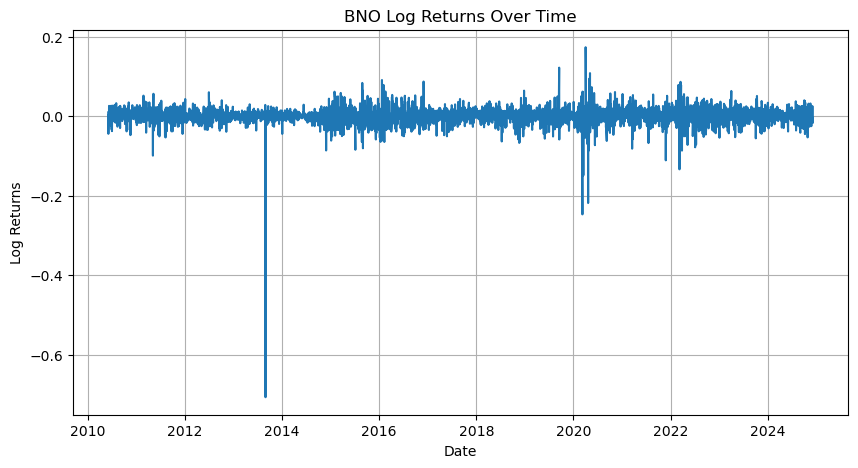

BNO ADF Test Results:
ADF Statistic: -43.553
p-value: 0.000
Critical Values:
   1%: -3.432
   5%: -2.862
   10%: -2.567




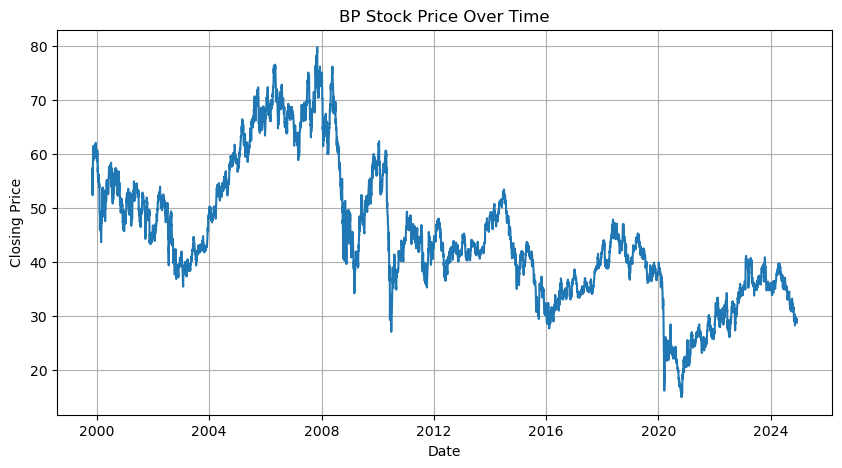

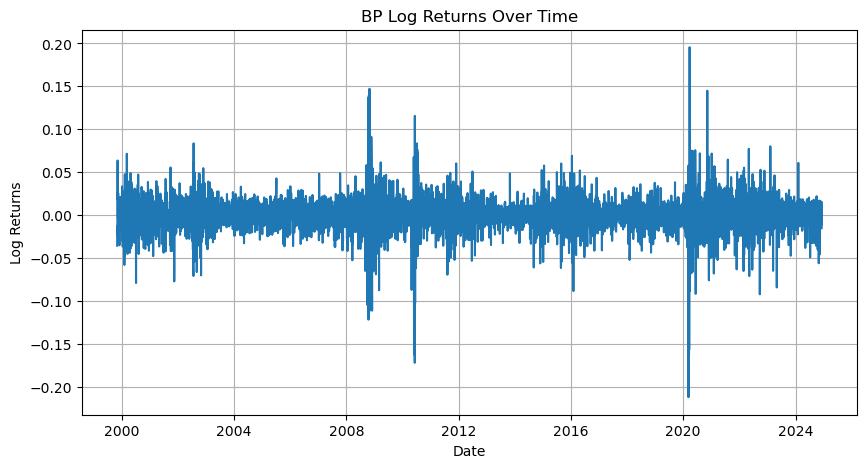

BP ADF Test Results:
ADF Statistic: -15.552
p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




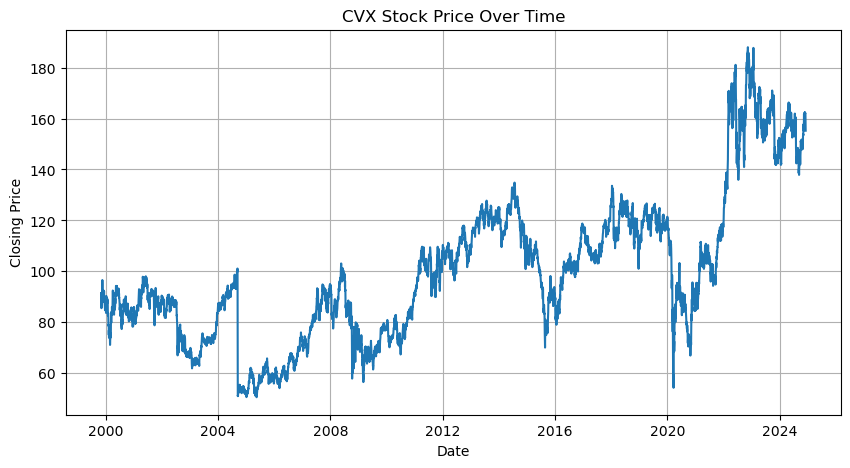

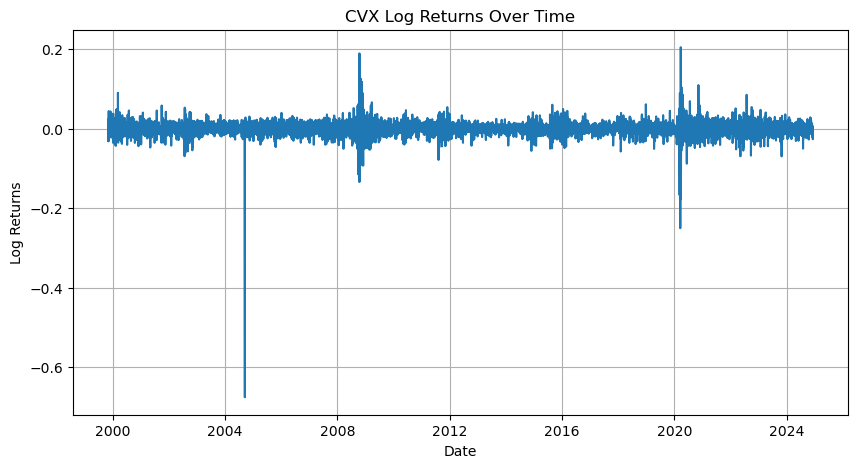

CVX ADF Test Results:
ADF Statistic: -20.251
p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




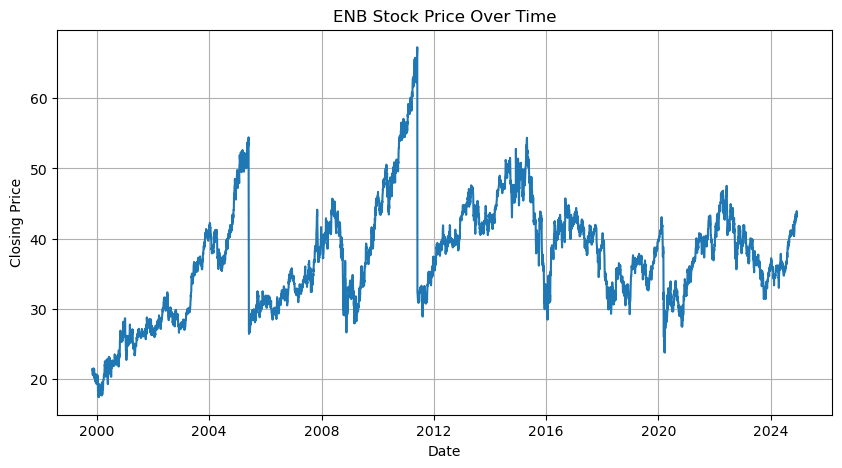

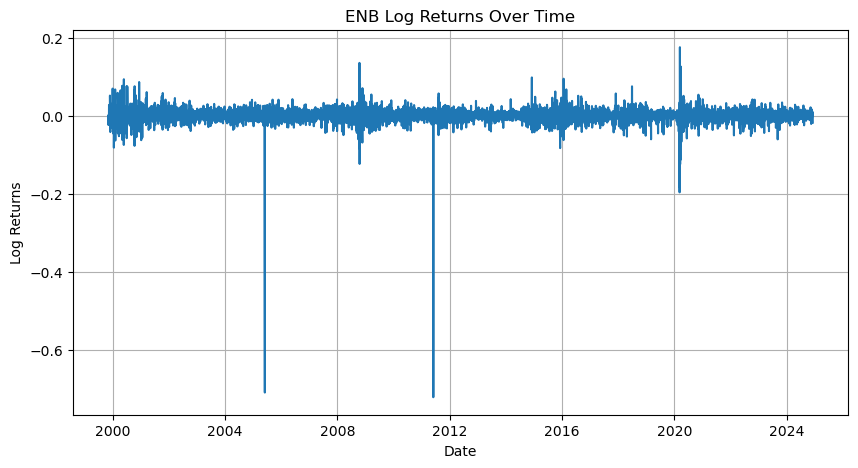

ENB ADF Test Results:
ADF Statistic: -83.297
p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




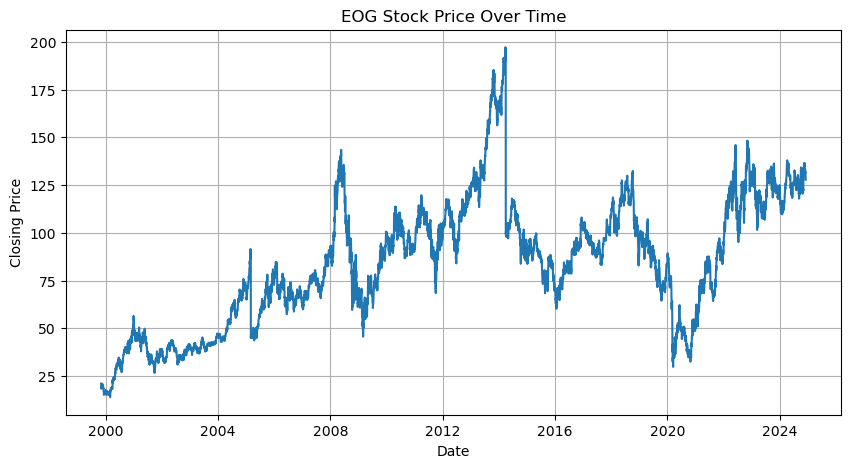

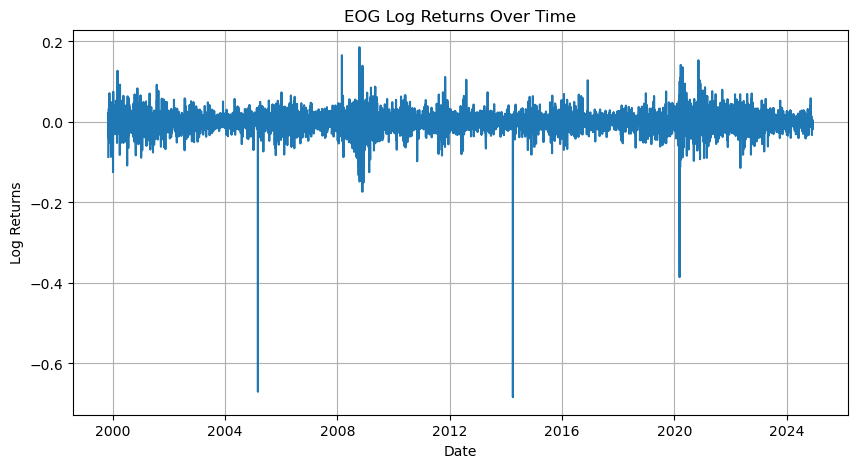

EOG ADF Test Results:
ADF Statistic: -41.139
p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




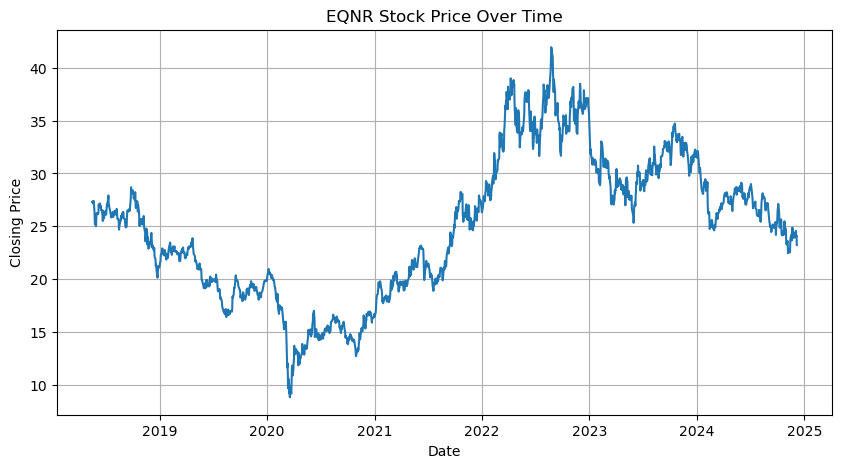

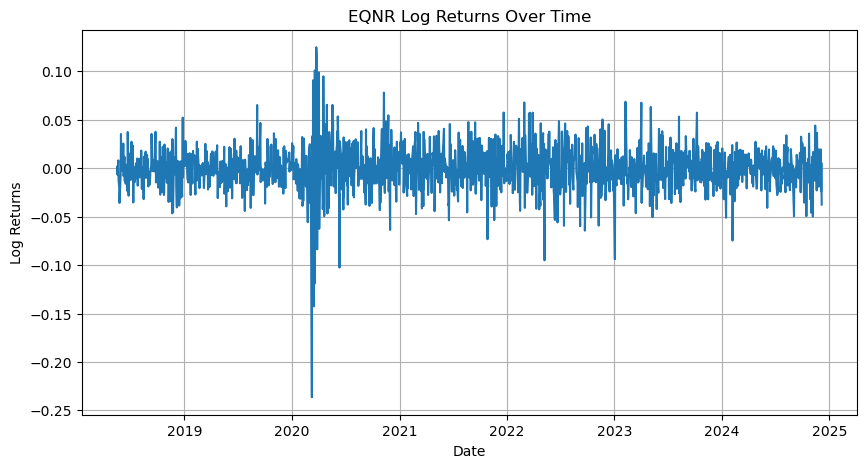

EQNR ADF Test Results:
ADF Statistic: -14.188
p-value: 0.000
Critical Values:
   1%: -3.434
   5%: -2.863
   10%: -2.568




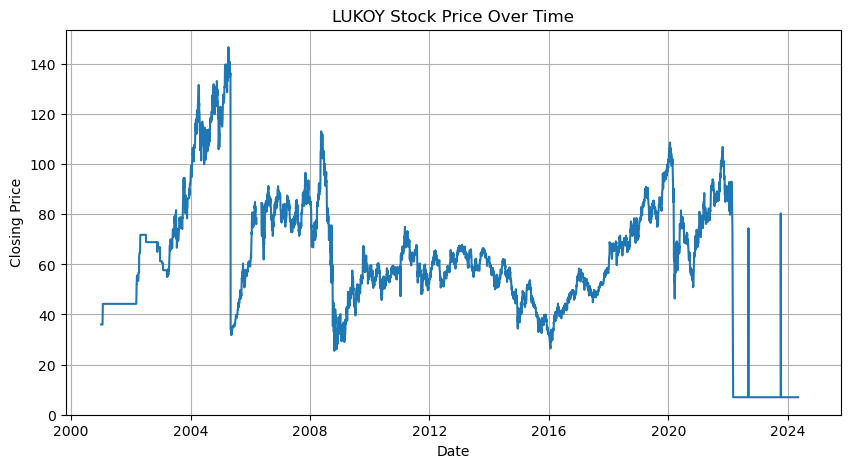

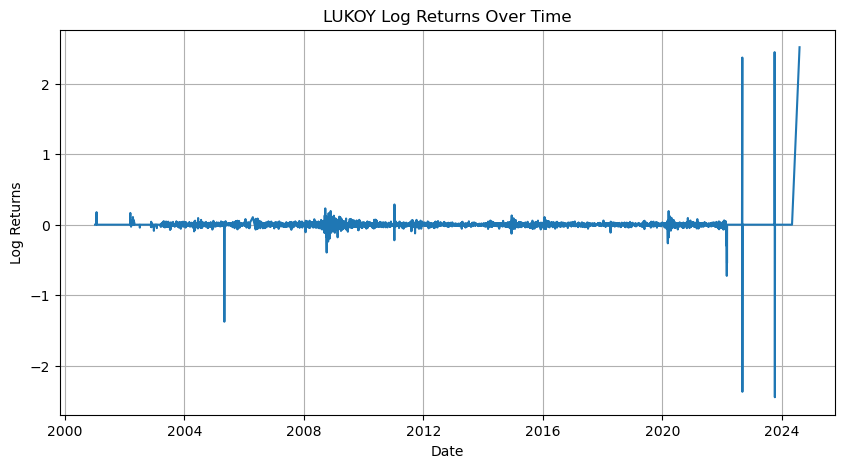

LUKOY ADF Test Results:
ADF Statistic: -29.082
p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




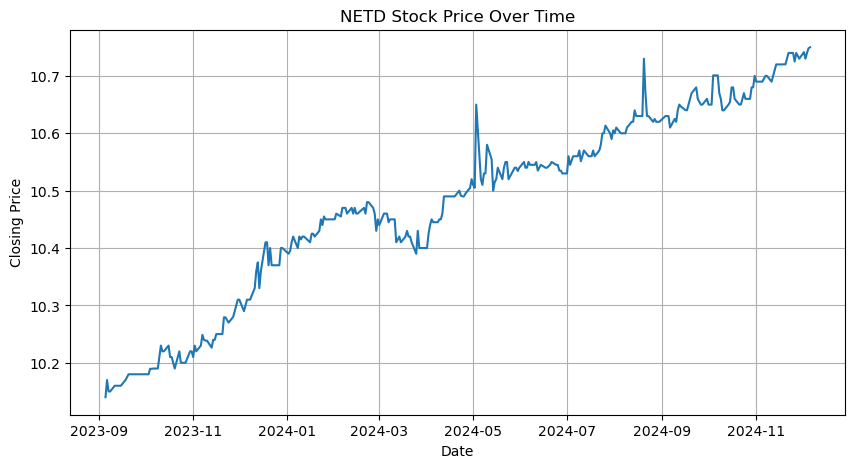

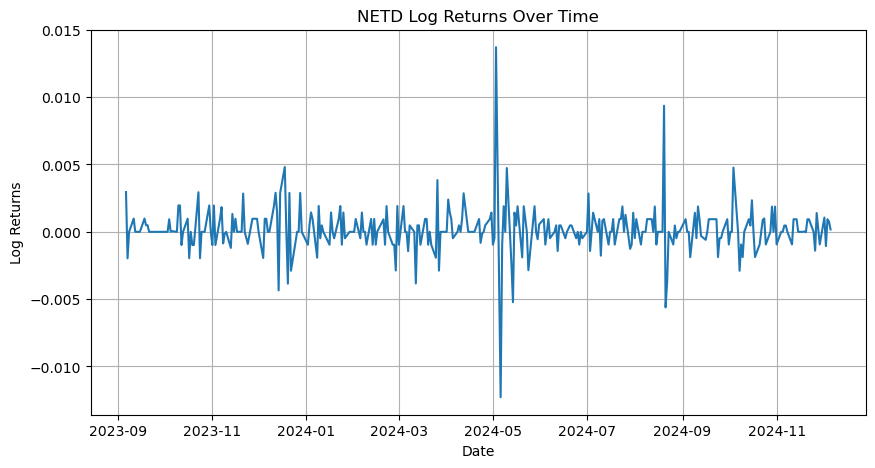

NETD ADF Test Results:
ADF Statistic: -12.956
p-value: 0.000
Critical Values:
   1%: -3.451
   5%: -2.871
   10%: -2.572




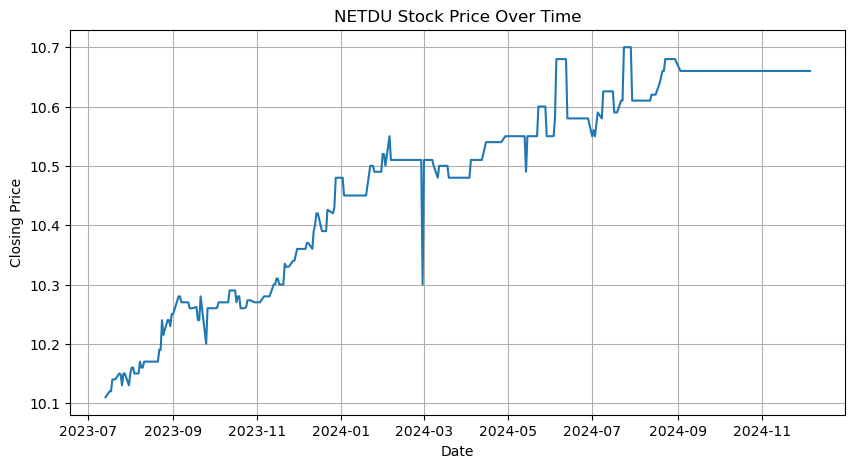

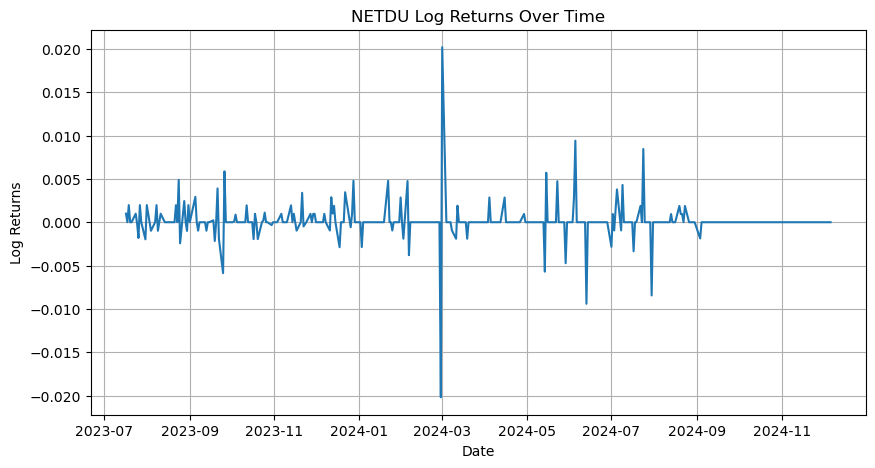

NETDU ADF Test Results:
ADF Statistic: -11.027
p-value: 0.000
Critical Values:
   1%: -3.449
   5%: -2.870
   10%: -2.571




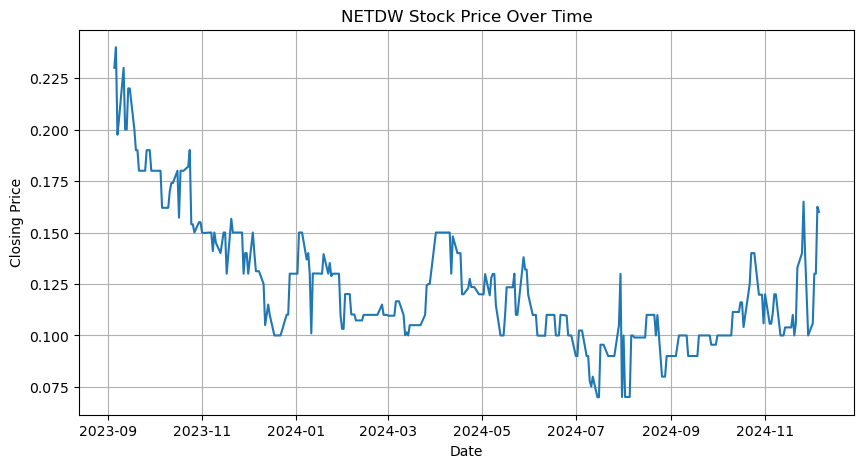

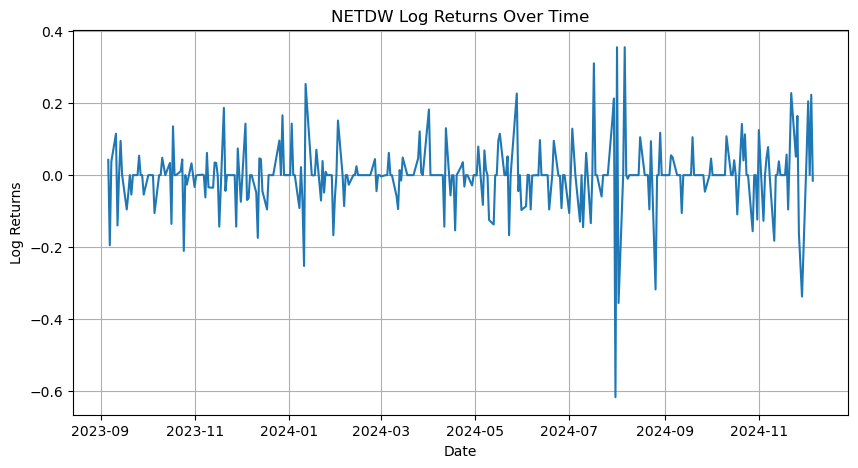

NETDW ADF Test Results:
ADF Statistic: -11.166
p-value: 0.000
Critical Values:
   1%: -3.451
   5%: -2.871
   10%: -2.572




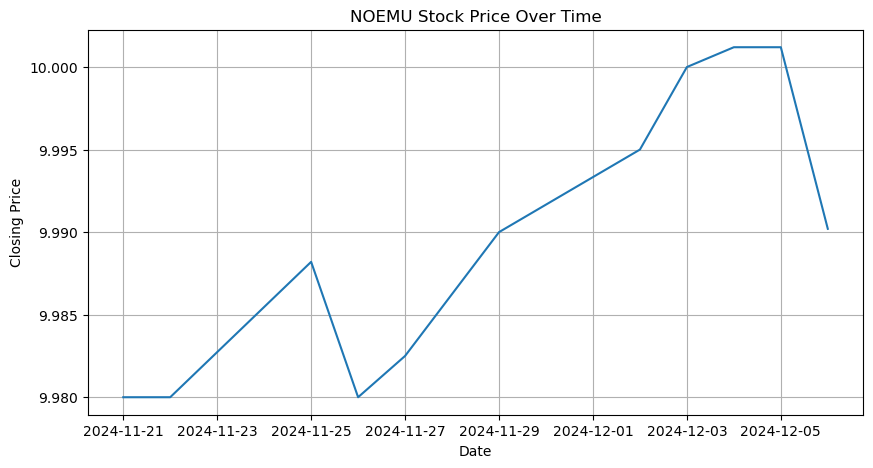

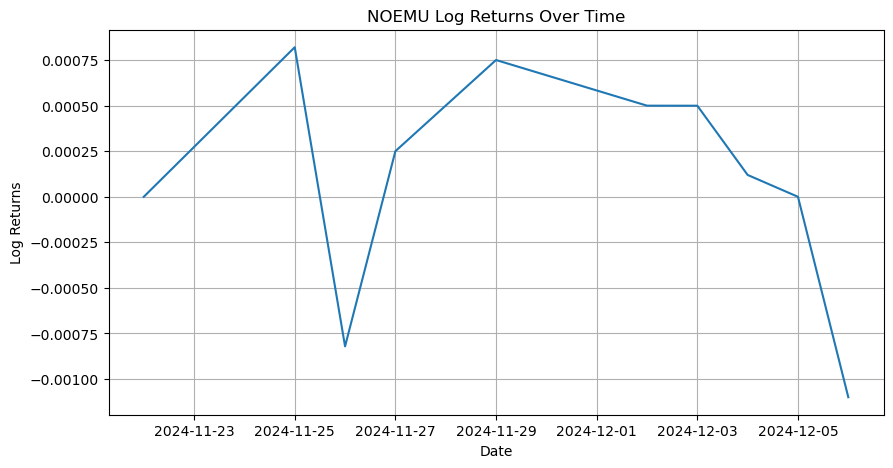

NOEMU ADF Test Results:
ADF Statistic: -2.225
p-value: 0.197
Critical Values:
   1%: -4.473
   5%: -3.290
   10%: -2.772




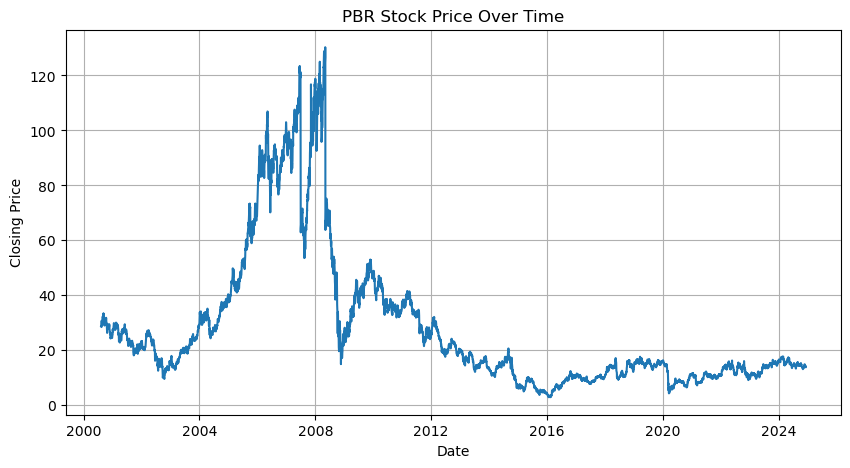

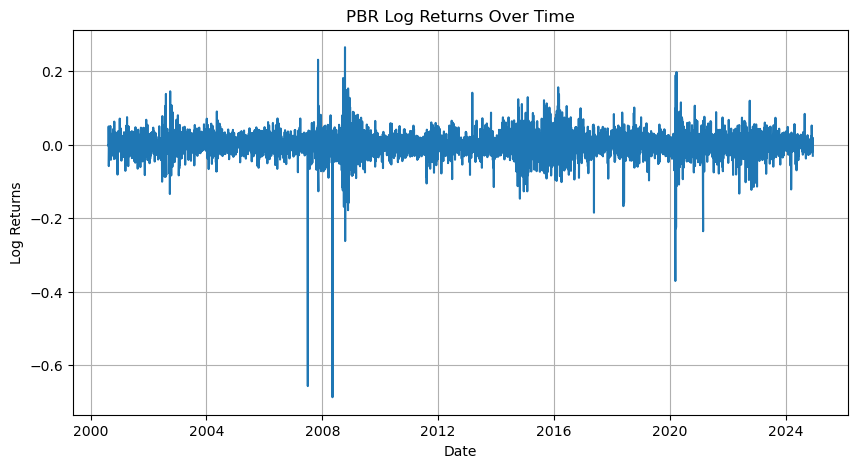

PBR ADF Test Results:
ADF Statistic: -27.809
p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




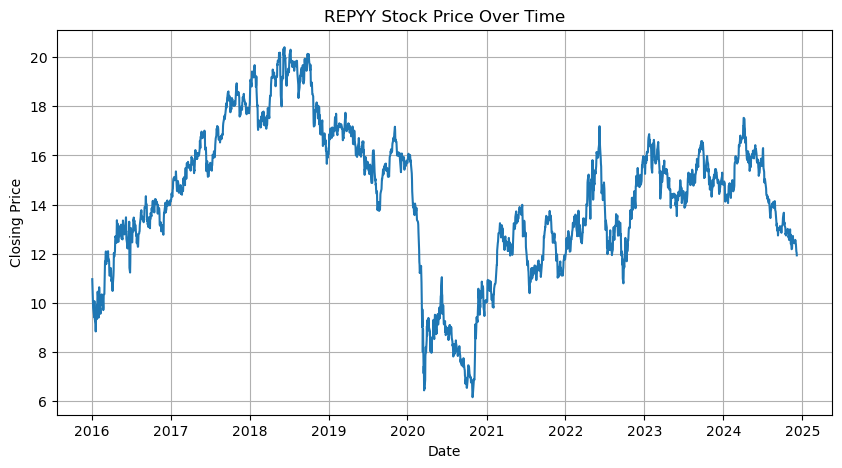

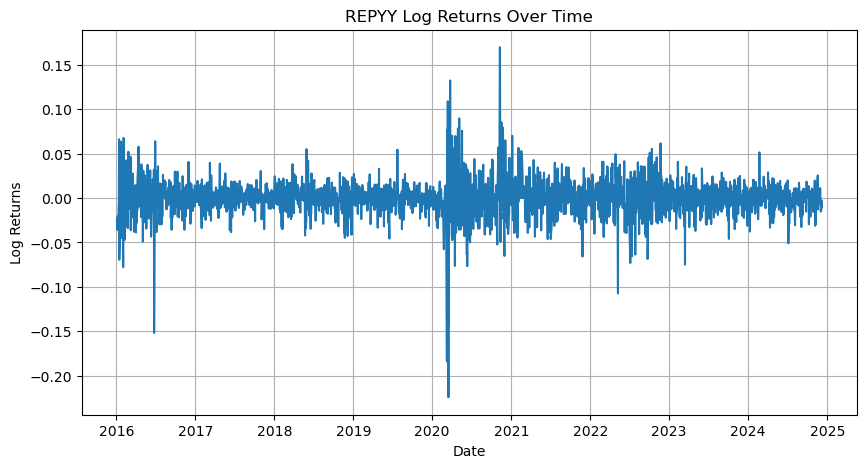

REPYY ADF Test Results:
ADF Statistic: -16.394
p-value: 0.000
Critical Values:
   1%: -3.433
   5%: -2.863
   10%: -2.567




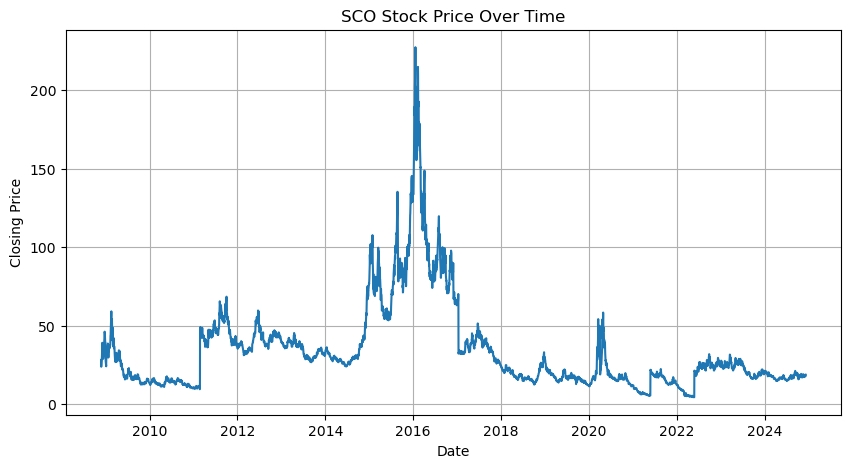

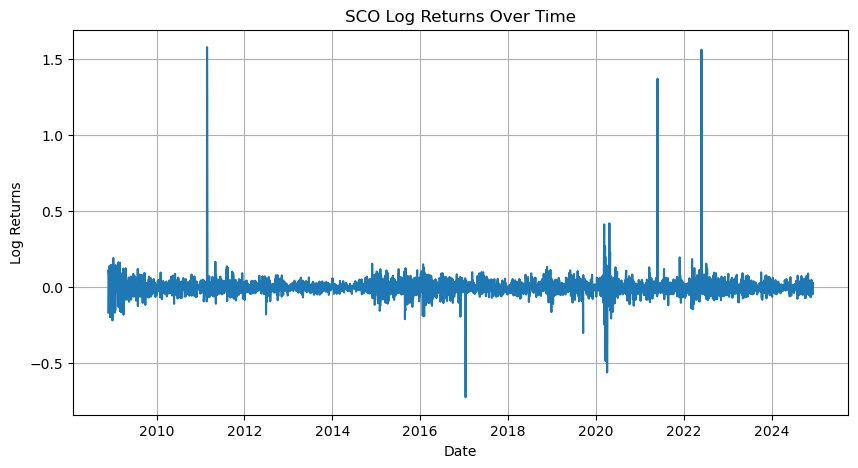

SCO ADF Test Results:
ADF Statistic: -39.025
p-value: 0.000
Critical Values:
   1%: -3.432
   5%: -2.862
   10%: -2.567




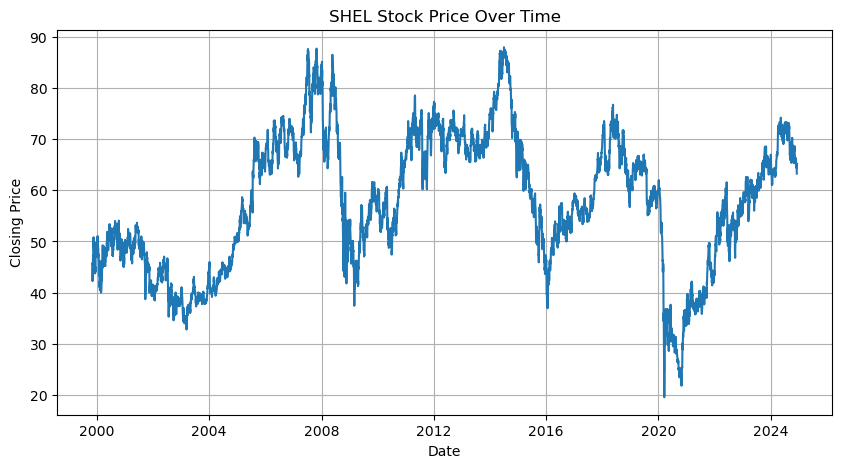

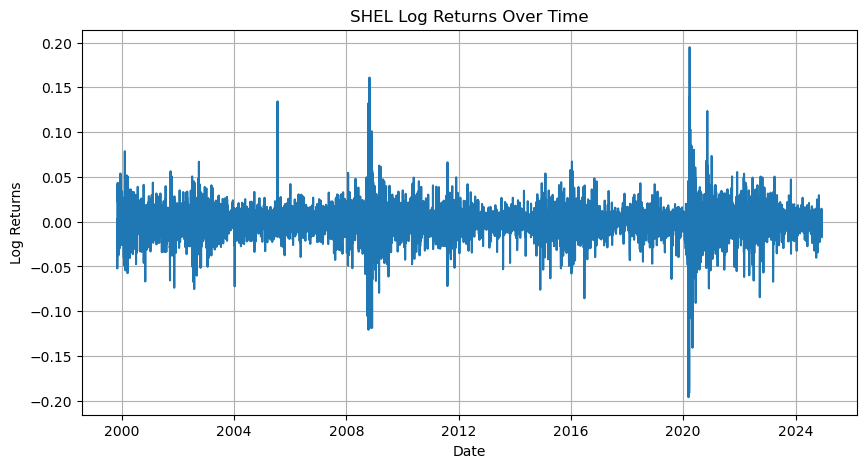

SHEL ADF Test Results:
ADF Statistic: -19.486
p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




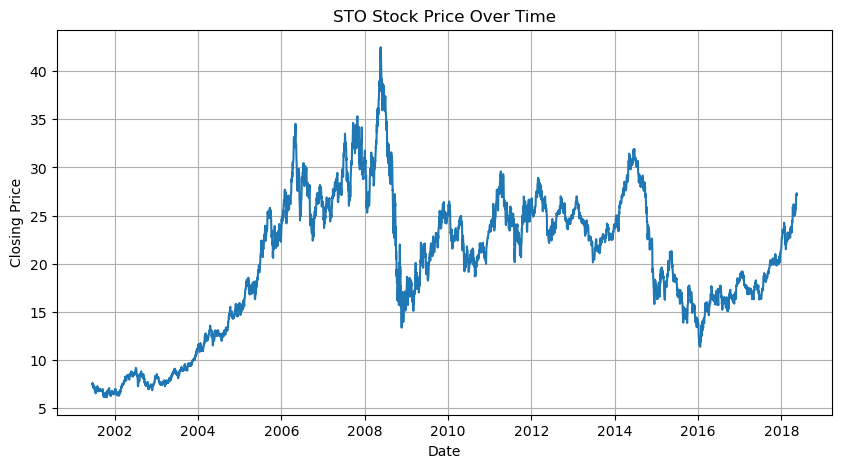

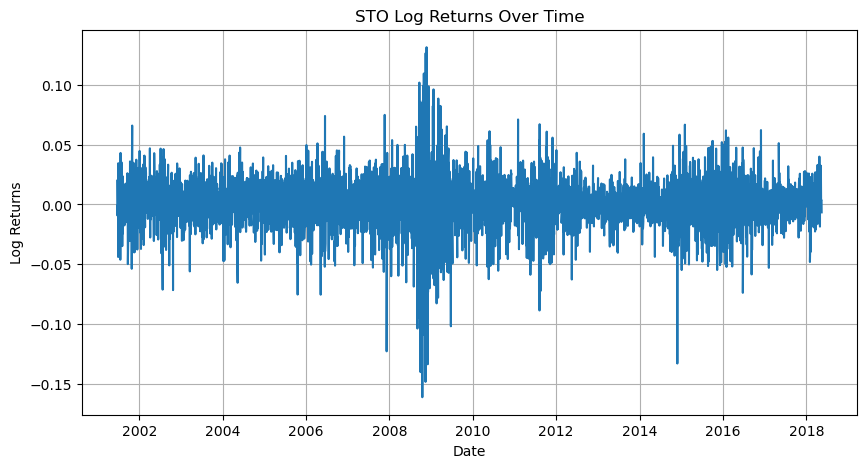

STO ADF Test Results:
ADF Statistic: -14.972
p-value: 0.000
Critical Values:
   1%: -3.432
   5%: -2.862
   10%: -2.567




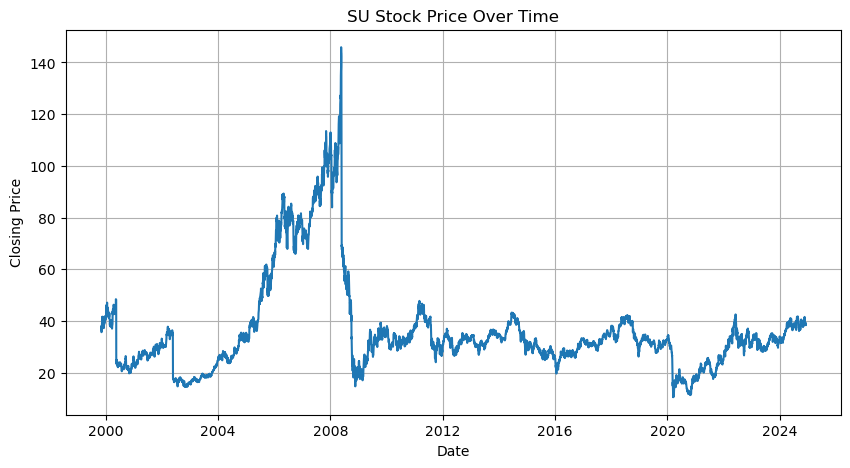

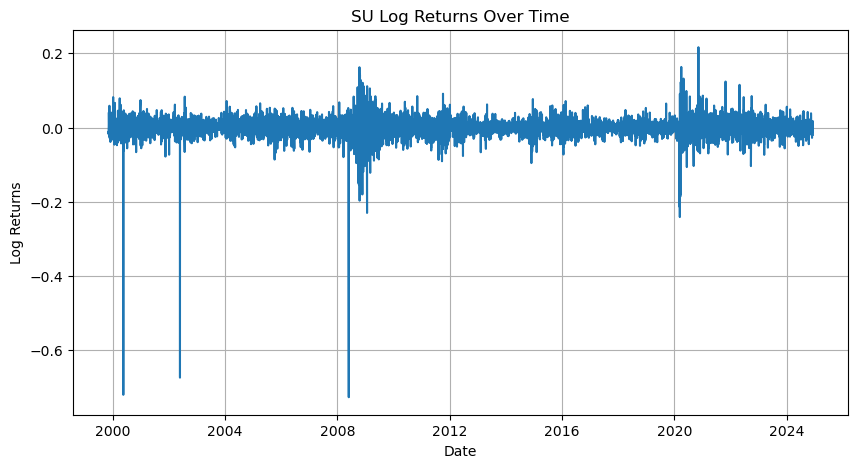

SU ADF Test Results:
ADF Statistic: -17.773
p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




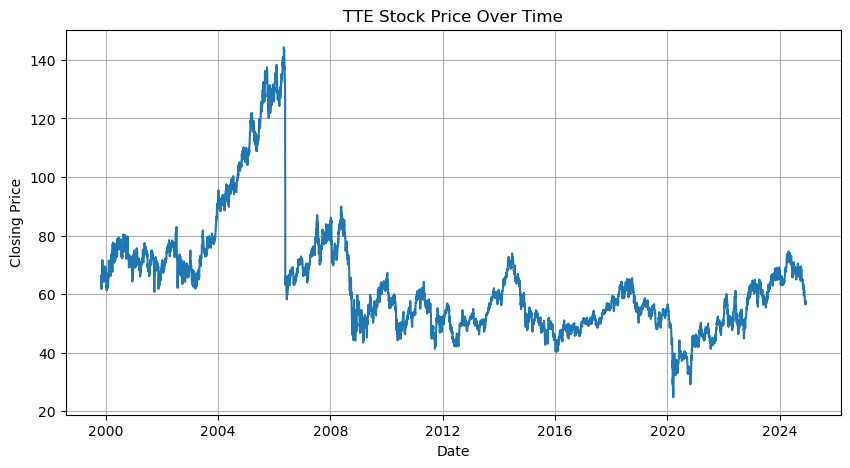

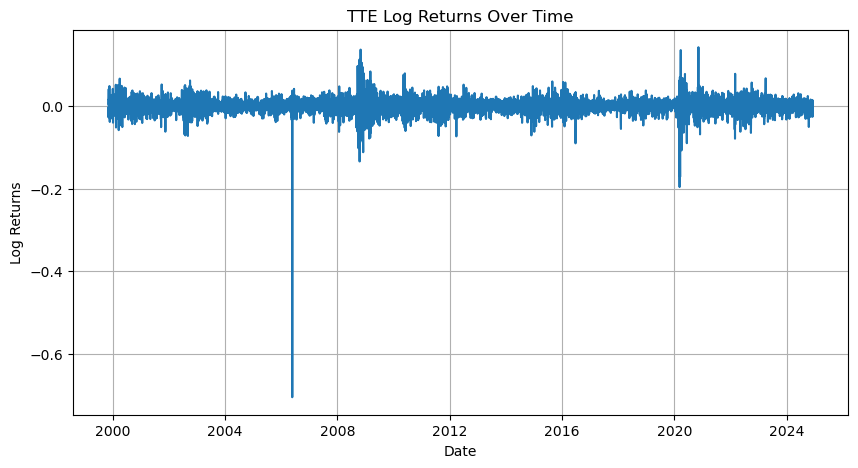

TTE ADF Test Results:
ADF Statistic: -58.157
p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




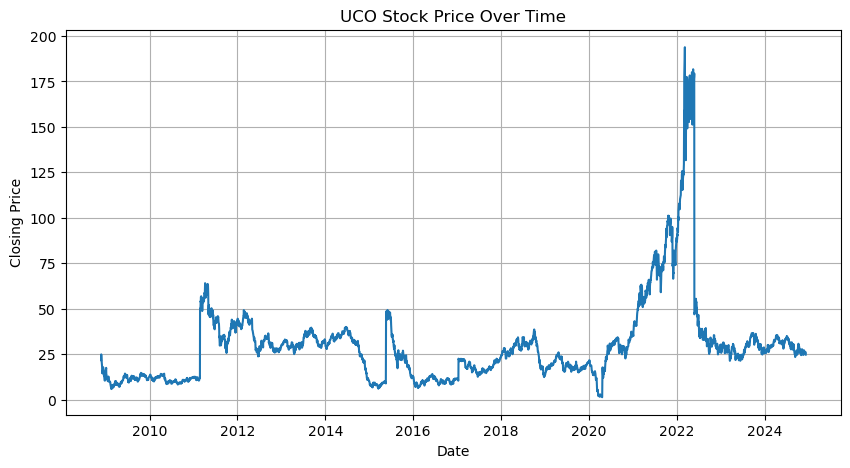

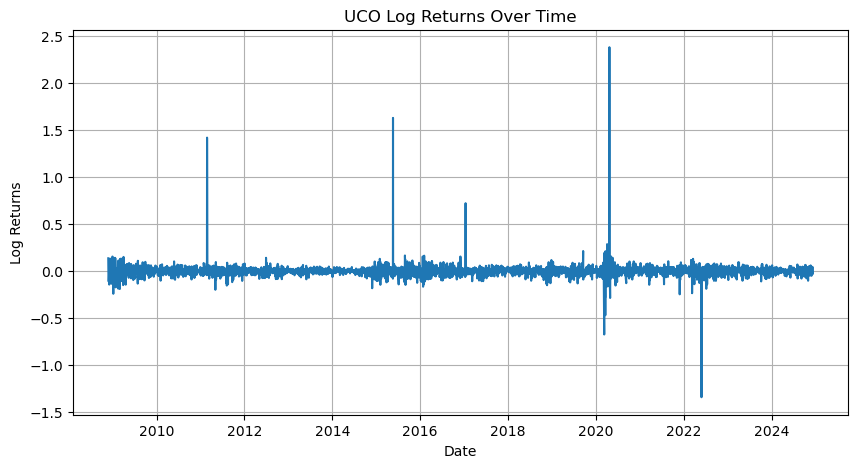

UCO ADF Test Results:
ADF Statistic: -12.120
p-value: 0.000
Critical Values:
   1%: -3.432
   5%: -2.862
   10%: -2.567




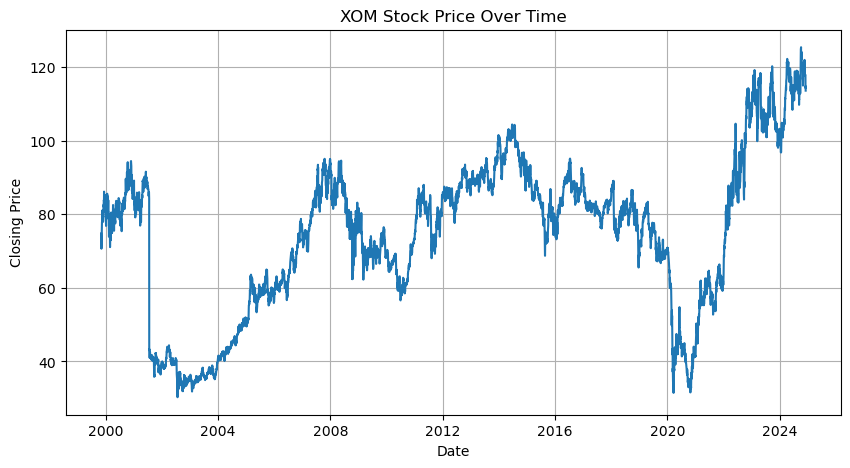

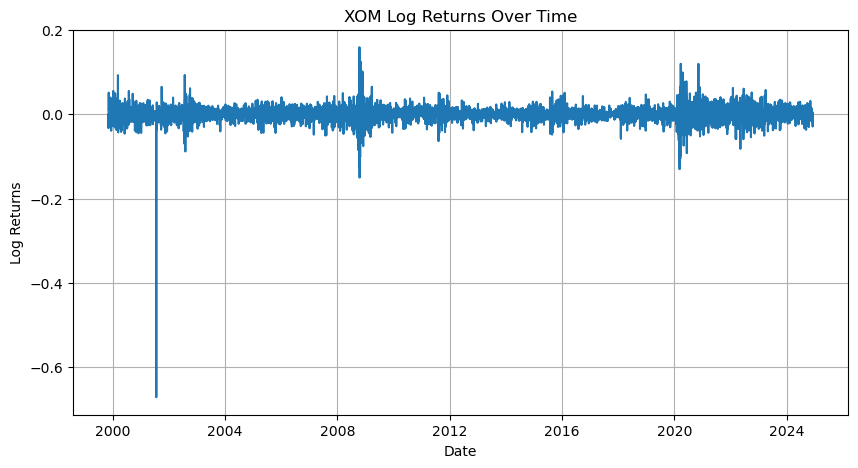

XOM ADF Test Results:
ADF Statistic: -59.678
p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




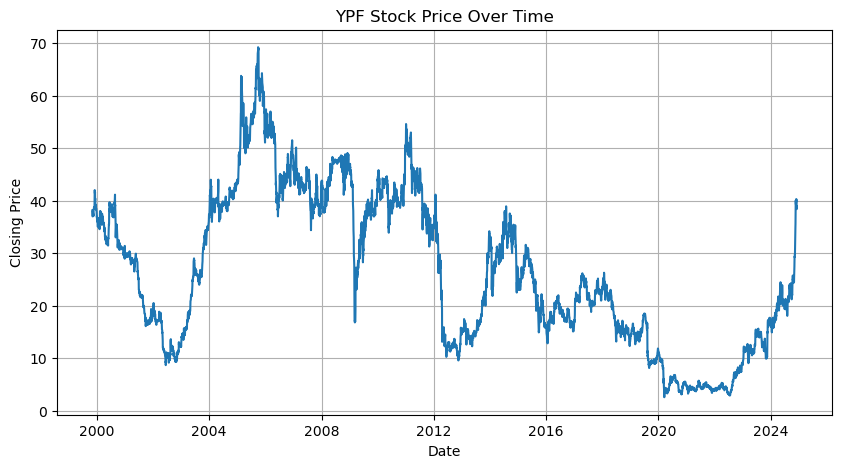

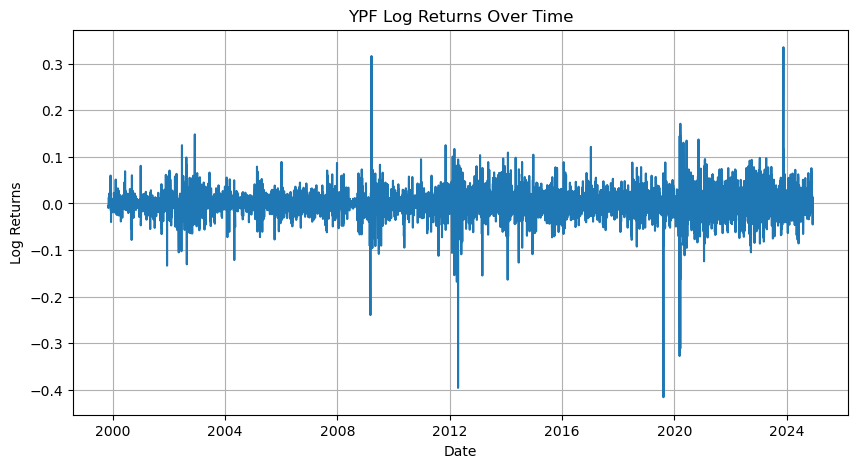

YPF ADF Test Results:
ADF Statistic: -36.621
p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




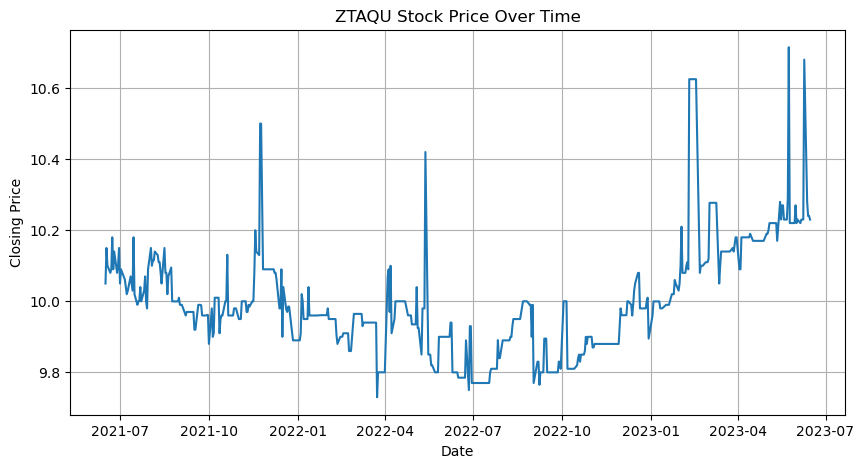

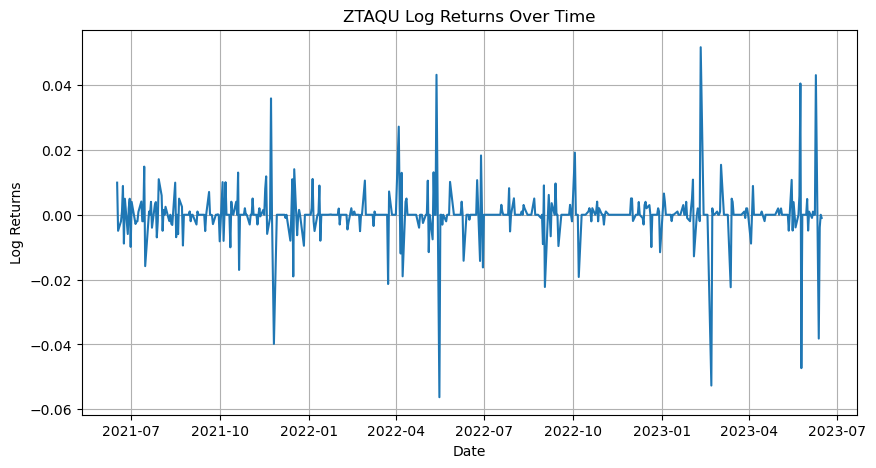

ZTAQU ADF Test Results:
ADF Statistic: -9.510
p-value: 0.000
Critical Values:
   1%: -3.444
   5%: -2.867
   10%: -2.570




In [8]:
# Iterate over each stock
for ticker in stocks_close.columns:
    # Plot the closing price
    plt.figure(figsize=(10, 5))
    plt.plot(stocks_close.index, stocks_close[ticker])
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'{ticker} Stock Price Over Time')
    plt.grid()
    plt.show()
    
    # Ensure data is numeric and handle missing values
    stock_data = pd.to_numeric(stocks_close[ticker], errors='coerce').dropna()
    
    # Compute log returns
    log_returns = np.log(stock_data).diff()
    
    # Plot the log returns
    plt.figure(figsize=(10, 5))
    plt.plot(log_returns.index, log_returns)
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.title(f'{ticker} Log Returns Over Time')
    plt.grid()
    plt.show()
    
    # Perform Augmented Dickey-Fuller test
    adf_test = adfuller(log_returns.dropna())
    print(f'{ticker} ADF Test Results:')
    print(f'ADF Statistic: {adf_test[0]:.3f}')
    print(f'p-value: {adf_test[1]:.3f}')
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print(f'   {key}: {value:.3f}')
    print('\n')

Processing BNO...


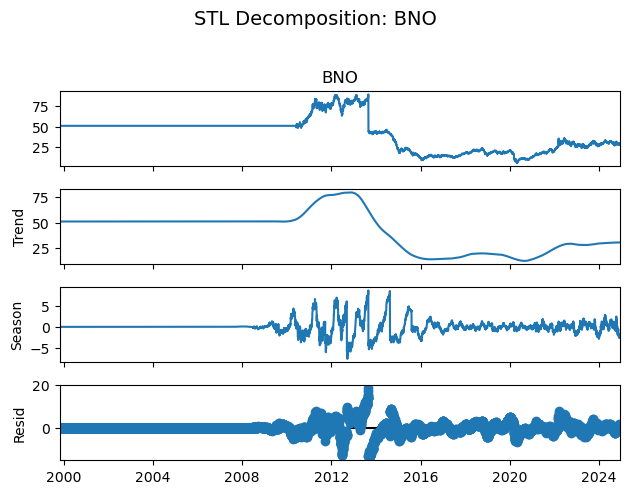

Processing BP...


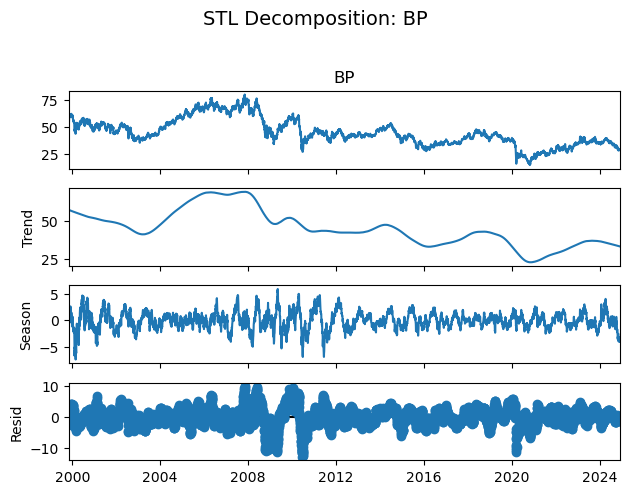

Processing CVX...


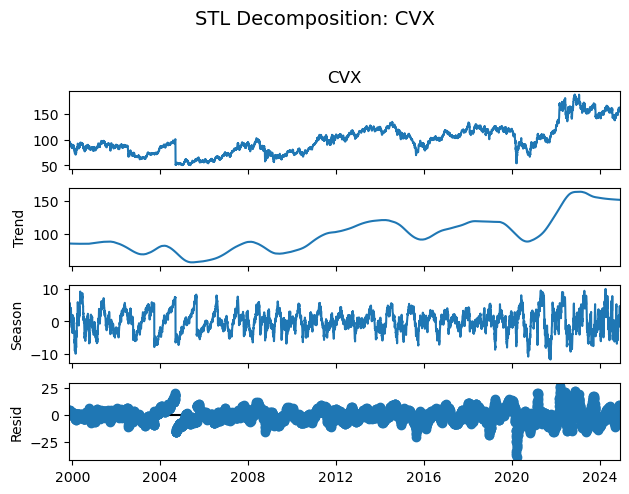

Processing ENB...


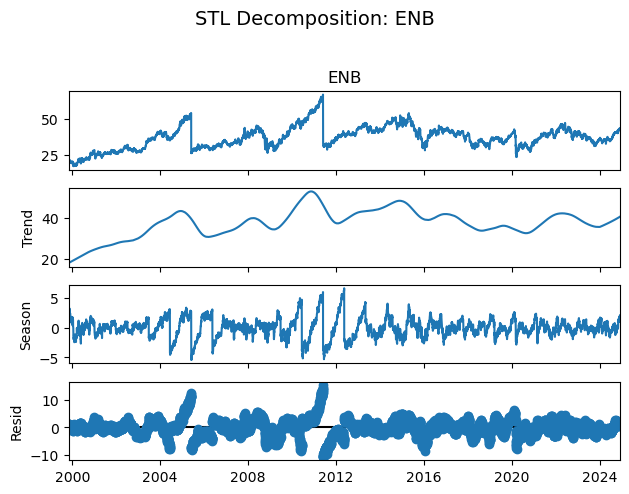

Processing EOG...


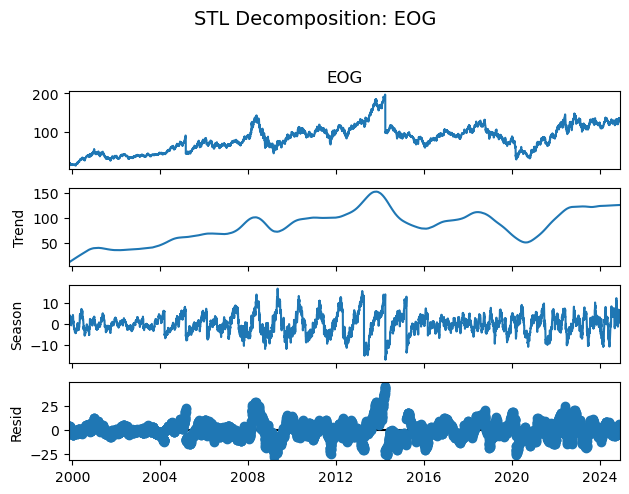

Processing EQNR...


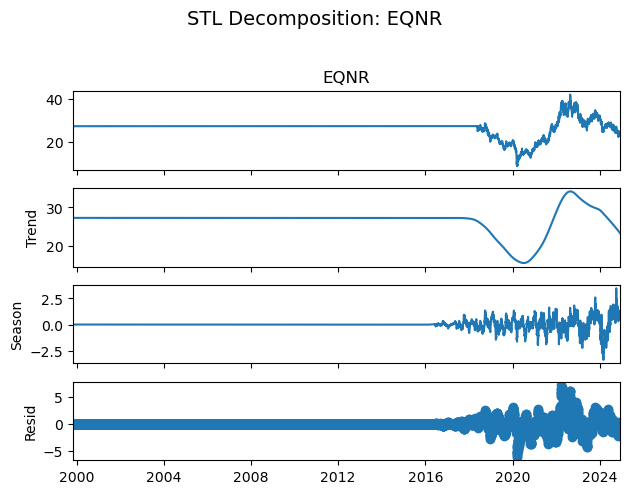

Processing LUKOY...


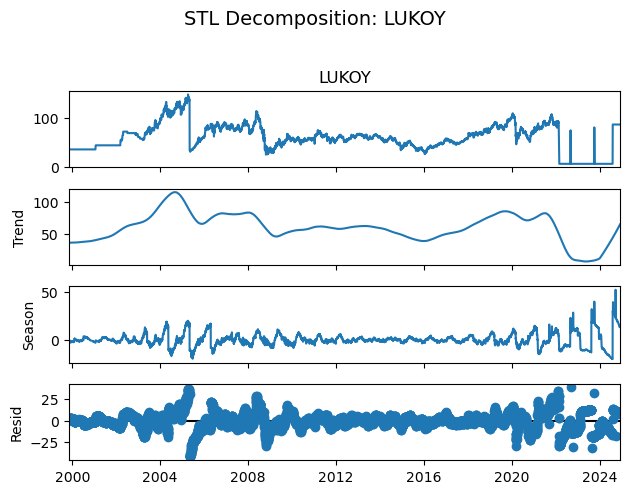

Processing NETD...


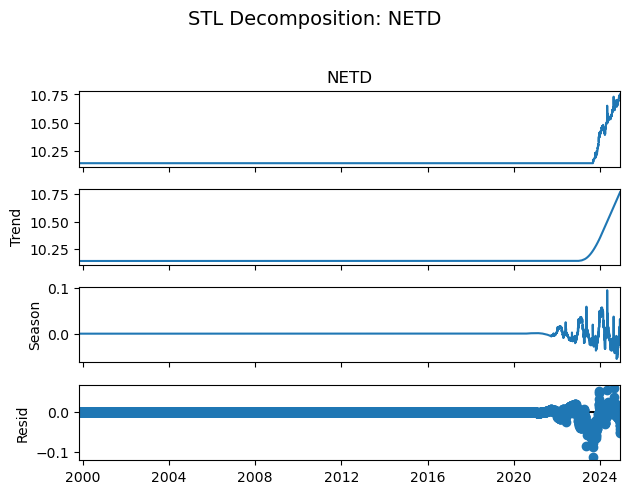

Processing NETDU...


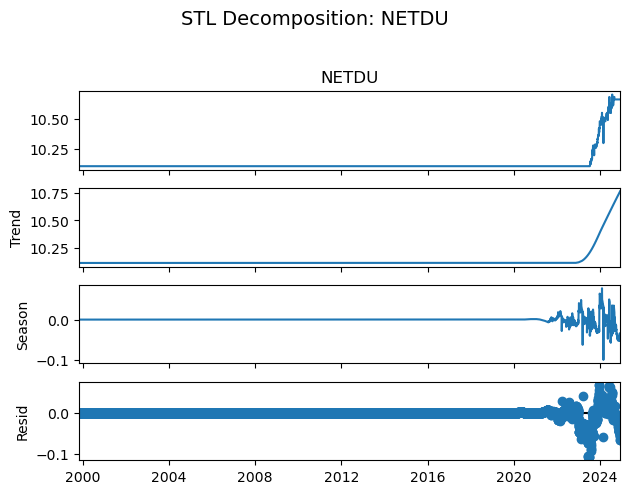

Processing NETDW...


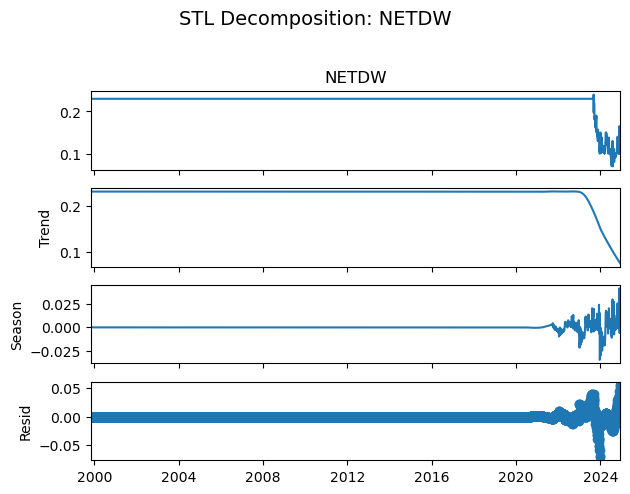

Processing NOEMU...


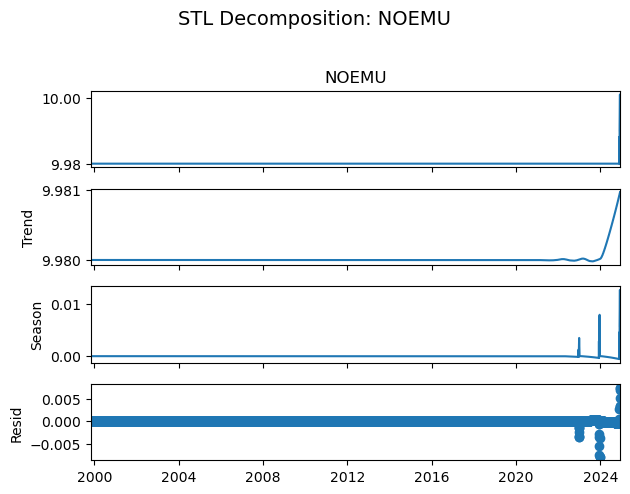

Processing PBR...


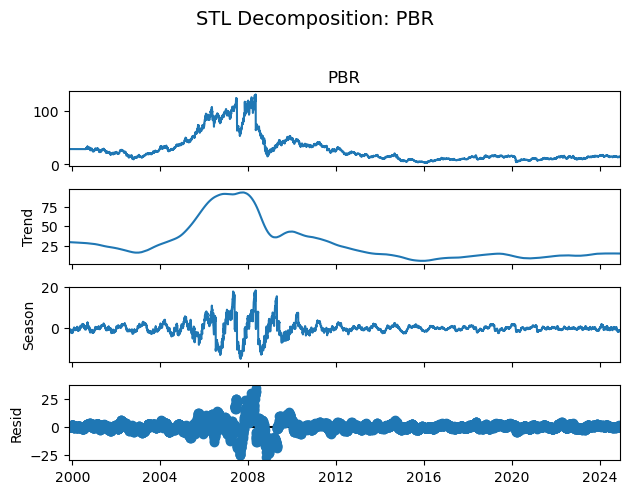

Processing REPYY...


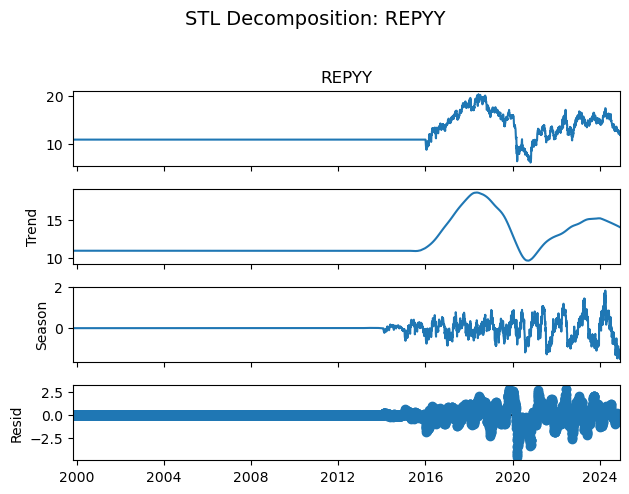

Processing SCO...


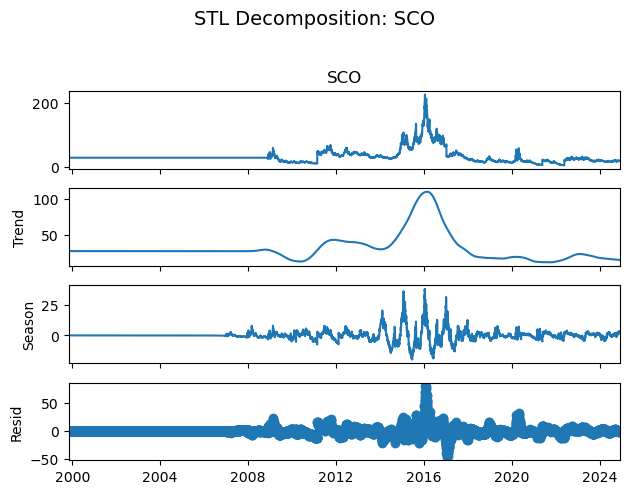

Processing SHEL...


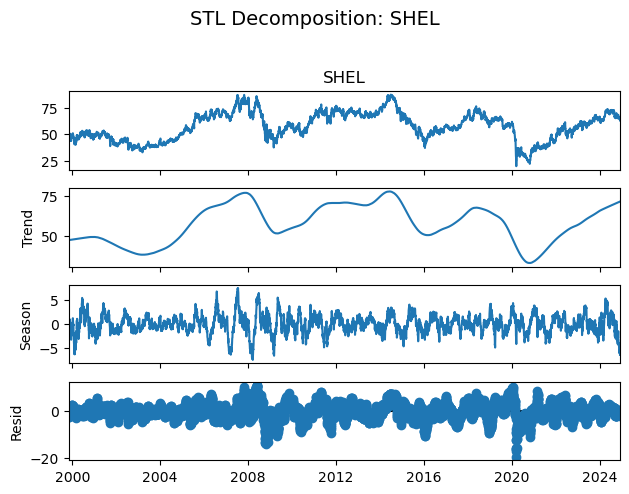

Processing STO...


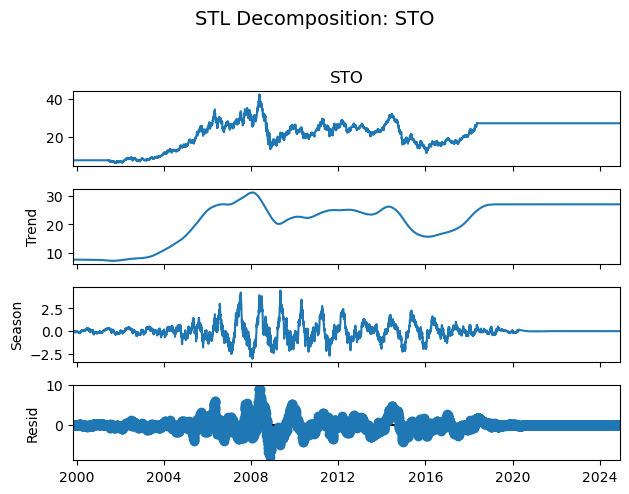

Processing SU...


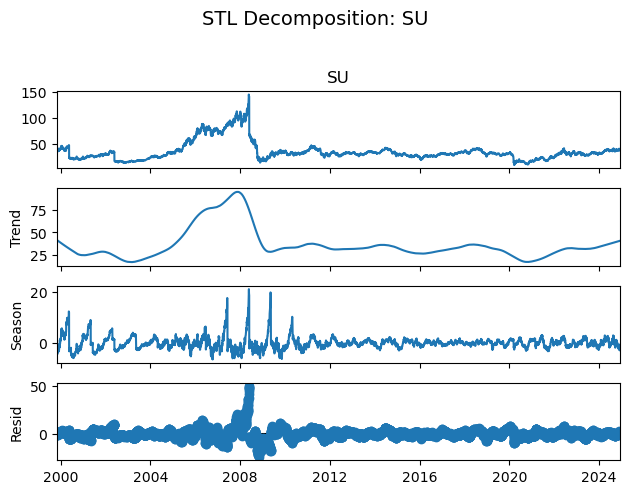

Processing TTE...


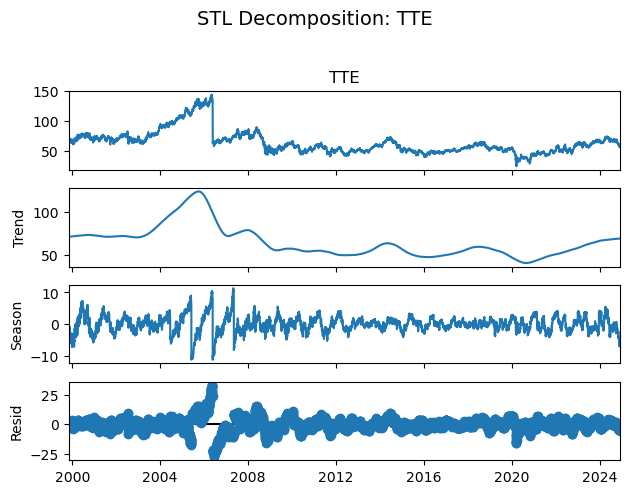

Processing UCO...


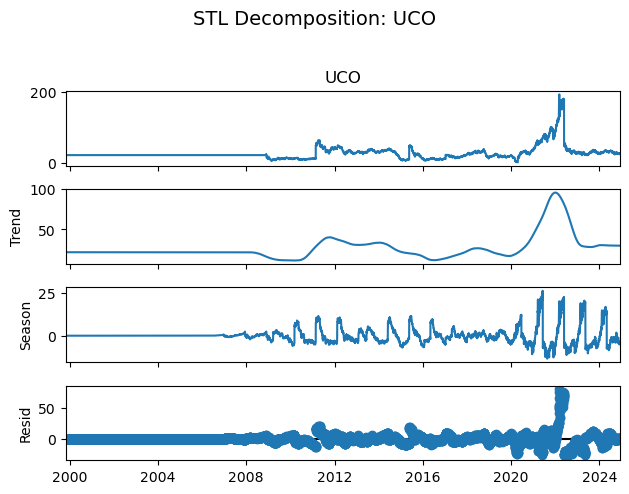

Processing XOM...


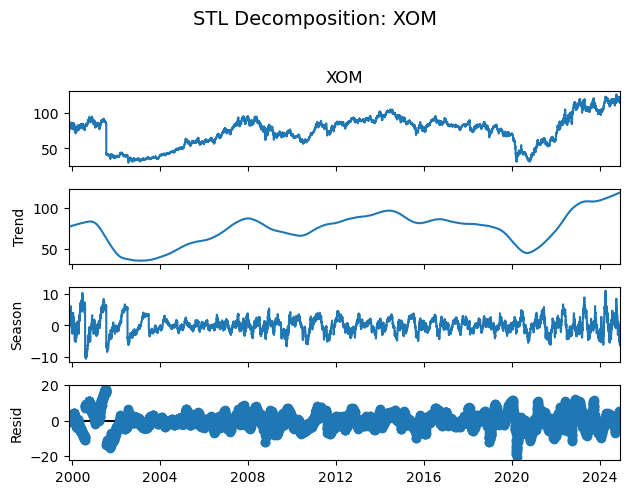

Processing YPF...


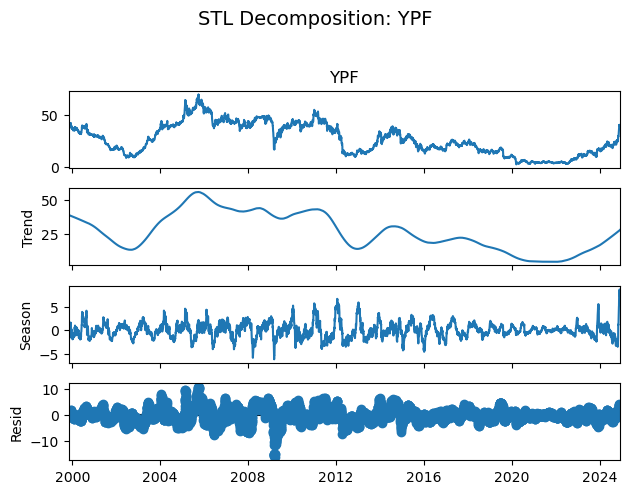

Processing ZTAQU...


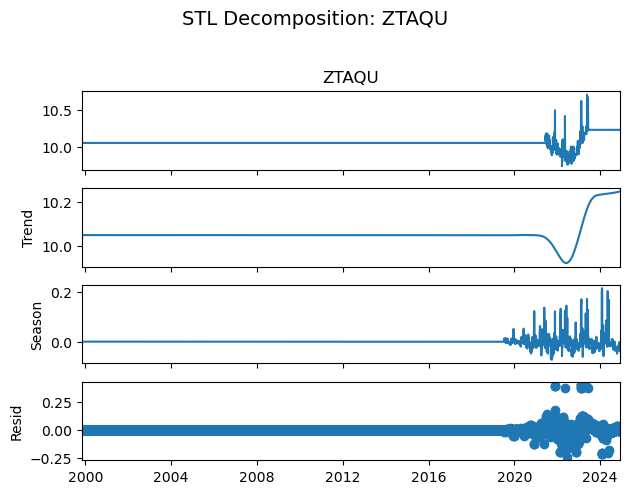

In [9]:
# Ensure 'date' column exists or is renamed
if 'date' not in stocks_close.columns:
    if stocks_close.index.name == 'date':  # Check if it's already set as the index
        stocks_close = stocks_close.reset_index()
    else:
        raise KeyError("'date' column is not found in the DataFrame")

# Set 'date' as the index and handle missing values
stocks_close = stocks_close.set_index('date')
stocks_close = stocks_close.fillna(method='ffill').fillna(method='bfill')  # Fill missing values

# Reindex with business days only if frequency is missing
if stocks_close.index.freq is None:
    stocks_close = stocks_close.asfreq('B').fillna(method='ffill').fillna(method='bfill')

# Perform STL decomposition
for ticker in stocks_close.columns:
    print(f"Processing {ticker}...")

    # Ensure there is valid data
    if stocks_close[ticker].isna().all():
        print(f"Skipping {ticker}: All values are NaN.")
        continue

    # Check data variability
    if stocks_close[ticker].nunique() <= 1:
        print(f"Skipping {ticker}: Insufficient data variability.")
        continue

    # Perform STL decomposition
    try:
        stl_decomposition = STL(stocks_close[ticker], period=252).fit()
        fig = stl_decomposition.plot()
        fig.suptitle(f'STL Decomposition: {ticker}', fontsize=14, y=1.02)  # Adjust title position
        plt.subplots_adjust(top=0.85)  # Add space above the plot
        plt.show()
    except Exception as e:
        print(f"Error processing {ticker}: {e}")